firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


/Users/davidpolashenski/Desktop/Athabasca_Model_Inputs/0426_ModernExtent.geojson
urn:ogc:def:crs:EPSG::32611
4.819025e+05, 5.781675e+06, 4.840380e+05, 5.784159e+06


Text(0.5, 0, 'meters')

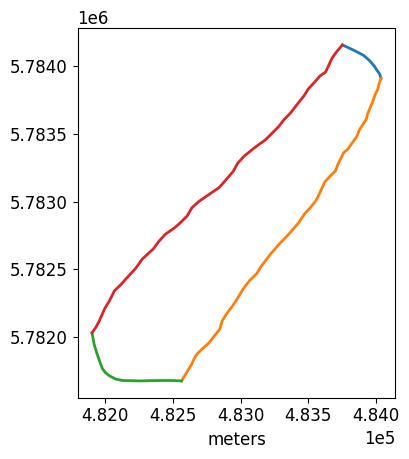

In [1]:
import firedrake
from firedrake import Constant, sqrt, inner, grad, dx
import tqdm
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
import numpy as np
import rasterio
import geojson
import icepack, icepack.plot, icepack.interpolate
#DEFINE SLIDING LAW HERE: WEERTMAN_SLIDING AS M
from icepack.constants import (
    ice_density as ρ_I, gravity as g, weertman_sliding_law as m
)


#Upload the GeoJSON file (Athabasca glacier outline drawn in QGIS)
outline_filename = '/Users/davidpolashenski/Desktop/Athabasca_Model_Inputs/0426_ModernExtent.geojson'
print(outline_filename)

with open(outline_filename, 'r') as outline_file:
    outline = geojson.load(outline_file)
print(outline['crs']['properties']['name'])


features = [feature['geometry'] for feature in outline['features']]
xmin, ymin, xmax, ymax = np.inf, np.inf, -np.inf, -np.inf

#don't know what factor of delta does here, I believe throwing off rasterio window below
#δ = 50e3
δ = 0
for feature in outline['features']:
    for line_string in feature['geometry']['coordinates']:
        xs = np.array(line_string)
        x, y = xs[:, 0], xs[:, 1]
        xmin, ymin = min(xmin, x.min() - δ), min(ymin, y.min() - δ)
        xmax, ymax = max(xmax, x.max() + δ), max(ymax, y.max() + δ)
        
print(f'{xmin:e}, {ymin:e}, {xmax:e}, {ymax:e}')

fig, axes = icepack.plot.subplots()

for feature in outline['features']:
    for line_string in feature['geometry']['coordinates']:
        xs = np.array(line_string)
        axes.plot(xs[:, 0], xs[:, 1], linewidth=2)

axes.set_xlabel('meters')

    


/Users/davidpolashenski/firedrake/src/PyOP2/pyop2/types/glob.py:55: UserWarning: PyOP2.Global has no comm, this is likely to break in parallel!
  warnings.warn("PyOP2.Global has no comm, this is likely to break in parallel!")


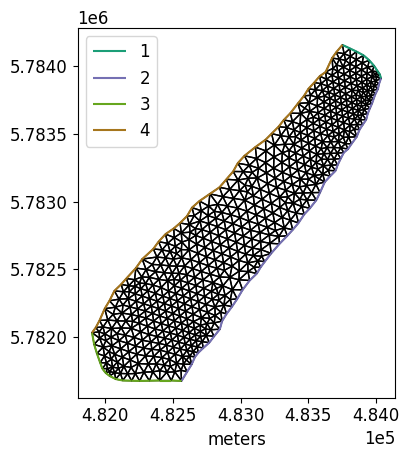

In [2]:
import pygmsh

#convert from GeoJSON, to .geo outline that gmsh can read as an input
geometry = icepack.meshing.collection_to_geo(outline)

with open('athabasca.geo', 'w') as geo_file:
    geo_file.write(geometry.get_code())

#mesh the .geo file 
!gmsh -2 -format msh2 -v 2 -o athabasca.msh athabasca.geo

#make a 2D footprint mesh and extrude it 
mesh2d = firedrake.Mesh('athabasca.msh')
mesh = firedrake.ExtrudedMesh(mesh2d, layers=1)

#plot mesh of the model domain
fig, axes = icepack.plot.subplots()
axes.set_xlabel('meters')
icepack.plot.triplot(mesh2d, axes=axes)

#legend with four boundary conditions; 1=front, 2 and 4=sides, 3=icefall
axes.legend(loc = "upper left")

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


/Users/davidpolashenski/firedrake/lib/python3.10/site-packages/rasterio/windows.py:314: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


Text(0.5, 0, 'meters')

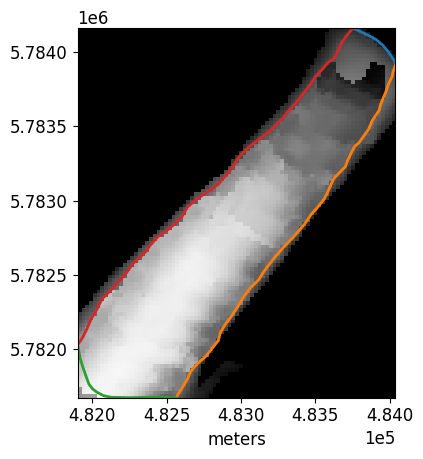

In [3]:



#GPR survey thickness data
thickness_filename = ('/Users/davidpolashenski/Desktop/Athabasca_Model_Inputs/Thickness_GPR_Faranotti.tif')
thickness_file = rasterio.open(thickness_filename, 'r')
thickness = thickness_file.read()

print(thickness)

#window the ice thickness data
height, width = thickness_file.height, thickness_file.width
transform = thickness_file.transform
window = rasterio.windows.from_bounds(
    left=xmin, bottom=ymin, right=xmax, top=ymax,
    width=width, height=height, transform=transform
)

#plot ice thickness
thickness = thickness_file.read(indexes=1, window=window, masked=True)

def subplots(*args, **kwargs):
    fig, axes = icepack.plot.subplots()
    xmin, ymin, xmax, ymax = rasterio.windows.bounds(window, transform)
    axes.imshow(
        thickness,
        cmap='Greys_r',
        vmin=0,
        vmax=301,
        extent=(xmin, xmax, ymin, ymax)
    )
    
    return fig, axes
    
fig, axes = subplots()

#overlay outline
for feature in outline['features']:
    for line_string in feature['geometry']['coordinates']:
        xs = np.array(line_string)
        axes.plot(xs[:, 0], xs[:, 1], linewidth=2)

axes.set_xlabel('meters')




Text(0.5, 0, 'meters')

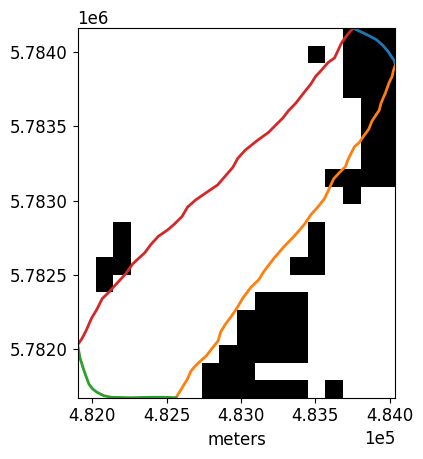

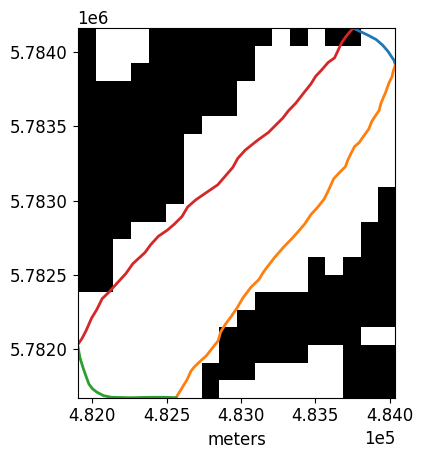

In [4]:
#Add Landsat vx and vy data over the domain

#Landsat vx data annual average m/yr
vx_filename = ('/Users/davidpolashenski/Desktop/athabasca_model_inputs/l8_velo_vx_ma.tif')
vx_file = rasterio.open(vx_filename, 'r')
vx = vx_file.read()

height, width = vx_file.height, vx_file.width
transform = vx_file.transform
window = rasterio.windows.from_bounds(
    left=xmin, bottom=ymin, right=xmax, top=ymax,
    width=width, height=height, transform=transform)
vx = vx_file.read(indexes=1, window=window, masked=True)

def subplots(*args, **kwargs):
    fig, axes = icepack.plot.subplots()
    xmin, ymin, xmax, ymax = rasterio.windows.bounds(window, transform)
    axes.imshow(
        vx,
        cmap='Greys_r',
        vmin=0,
        vmax=0.1,
        extent=(xmin, xmax, ymin, ymax)
    )
    
    return fig, axes
    
fig, axes = subplots()

for feature in outline['features']:
    for line_string in feature['geometry']['coordinates']:
        xs = np.array(line_string)
        axes.plot(xs[:, 0], xs[:, 1], linewidth=2)

axes.set_xlabel('meters')

#Landsat vy data annual average m/yr
vy_filename = ('/Users/davidpolashenski/Desktop/athabasca_model_inputs/l8_velo_vY_ma.tif')
vy_file = rasterio.open(vy_filename, 'r')
vy = vy_file.read()

height, width = vy_file.height, vy_file.width
transform = vy_file.transform
window = rasterio.windows.from_bounds(
    left=xmin, bottom=ymin, right=xmax, top=ymax,
    width=width, height=height, transform=transform)
vy = vy_file.read(indexes=1, window=window, masked=True)

#Define a windowing subplot function, vmin/max definies colorbar scale
def subplots(*args, **kwargs):
    fig, axes = icepack.plot.subplots()
    xmin, ymin, xmax, ymax = rasterio.windows.bounds(window, transform)
    axes.imshow(
        vy,
        cmap='Greys_r',
        vmin=0,
        vmax=.1,
        extent=(xmin, xmax, ymin, ymax)
    )
    
    return fig, axes
    
fig, axes = subplots()

for feature in outline['features']:
    for line_string in feature['geometry']['coordinates']:
        xs = np.array(line_string)
        axes.plot(xs[:, 0], xs[:, 1], linewidth=2)

axes.set_xlabel('meters')



array([[2301.7412, 2301.8823, 2302.9768, ..., 1967.4253, 1967.364 ,
        1967.3552],
       [2305.4668, 2305.493 , 2306.508 , ..., 1967.1847, 1967.0707,
        1967.009 ],
       [2309.2202, 2309.2642, 2310.1855, ..., 1966.7306, 1966.5688,
        1966.5763],
       ...,
       [2221.8682, 2221.8848, 2222.1587, ..., 2623.1436, 2624.8047,
        2626.5764],
       [2222.0413, 2222.0833, 2222.2012, ..., 2624.5933, 2626.653 ,
        2628.7075],
       [2222.4136, 2222.358 , 2222.4001, ..., 2626.8308, 2628.8596,
        2631.3755]], dtype=float32)

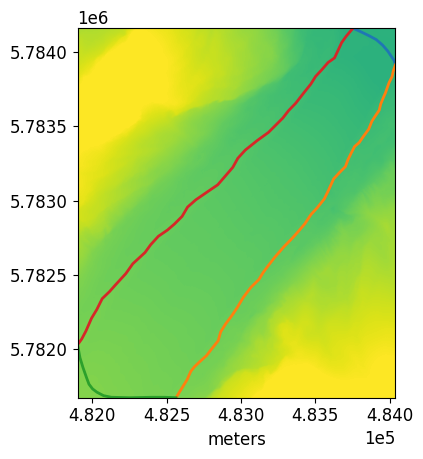

In [5]:
#Input surface elevation/DEM of glacier surface; modern lidar DEM
DEM_mod_filename = ('/Users/davidpolashenski/Desktop/athabasca_model_inputs/Athabasca_DEM.tif')

DEM_mod_file = rasterio.open(DEM_mod_filename, 'r')
DEM_mod = DEM_mod_file.read()

height, width = DEM_mod_file.height, DEM_mod_file.width
transform = DEM_mod_file.transform
window = rasterio.windows.from_bounds(
    left=xmin, bottom=ymin, right=xmax, top=ymax,
    width=width, height=height, transform=transform)
DEM_mod = DEM_mod_file.read(indexes=1, window=window, masked=True)

#read the elevation data out of masked array format from input file
DEM_mod = np.ma.getdata(DEM_mod)

#not sure how to add colorbar here...
def subplots(*args, **kwargs):
    fig, axes = icepack.plot.subplots()
    xmin, ymin, xmax, ymax = rasterio.windows.bounds(window, transform)
    axes.imshow(
        DEM_mod,
        cmap='viridis',
        vmin=1000,
        vmax=2500,
        extent=(xmin, xmax, ymin, ymax)
    )
    
    return fig, axes
    
fig, axes = subplots()

for feature in outline['features']:
    for line_string in feature['geometry']['coordinates']:
        xs = np.array(line_string)
        axes.plot(xs[:, 0], xs[:, 1], linewidth=2)

axes.set_xlabel('meters')
DEM_mod

array([[2317.0232, 2315.9038, 2315.0308, ..., 2038.1271, 2037.6274,
        2037.1057],
       [2321.4358, 2319.4658, 2316.6702, ..., 2038.4763, 2038.0184,
        2037.5283],
       [2325.222 , 2324.1873, 2320.72  , ..., 2038.7626, 2038.3379,
        2037.885 ],
       ...,
       [2279.8677, 2279.3193, 2278.4724, ..., 2623.1643, 2624.345 ,
        2626.3977],
       [2280.428 , 2279.794 , 2278.9844, ..., 2624.3342, 2625.6477,
        2627.7798],
       [2281.1372, 2280.5264, 2279.9387, ..., 2625.538 , 2627.4016,
        2629.9382]], dtype=float32)

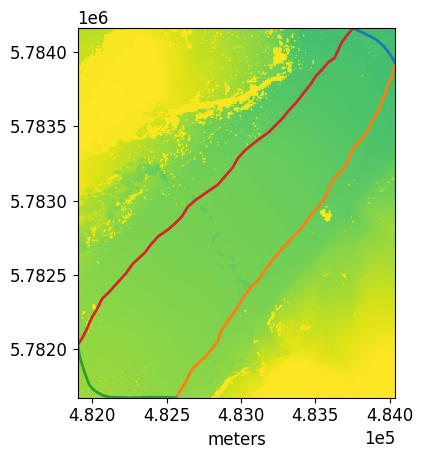

In [6]:

#Input surface elevation/DEM of glacier surface; historical, aerial DEM
DEM_filename = ('/Users/davidpolashenski/Desktop/athabasca_model_inputs/Ath_Hist_DEM_meanfilled.tif')

DEM_file = rasterio.open(DEM_filename, 'r')
DEM = DEM_file.read()

height, width = DEM_file.height, DEM_file.width
transform = DEM_file.transform
window = rasterio.windows.from_bounds(
    left=xmin, bottom=ymin, right=xmax, top=ymax,
    width=width, height=height, transform=transform)
DEM = DEM_file.read(indexes=1, window=window, masked=True)

#read the elevation data out of masked array format from input file
DEM = np.ma.getdata(DEM)

#not sure how to add colorbar here...
def subplots(*args, **kwargs):
    fig, axes = icepack.plot.subplots()
    xmin, ymin, xmax, ymax = rasterio.windows.bounds(window, transform)
    axes.imshow(
        DEM,
        cmap='viridis',
        vmin=1000,
        vmax=2500,
        extent=(xmin, xmax, ymin, ymax)
    )
    
    return fig, axes
    
fig, axes = subplots()

for feature in outline['features']:
    for line_string in feature['geometry']['coordinates']:
        xs = np.array(line_string)
        axes.plot(xs[:, 0], xs[:, 1], linewidth=2)

axes.set_xlabel('meters')
DEM

# code to replace all negative elevation values with 0
#DEM[DEM<0] = 0
#DEM



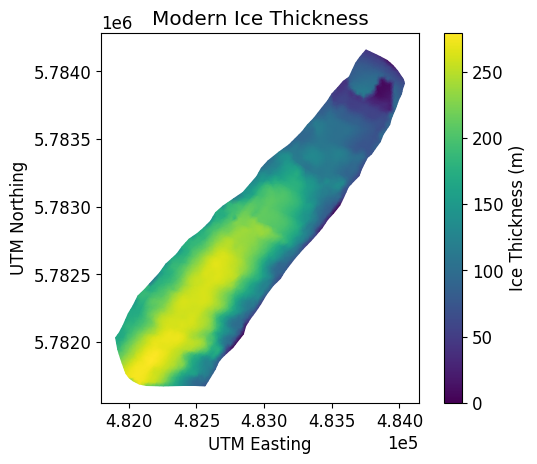

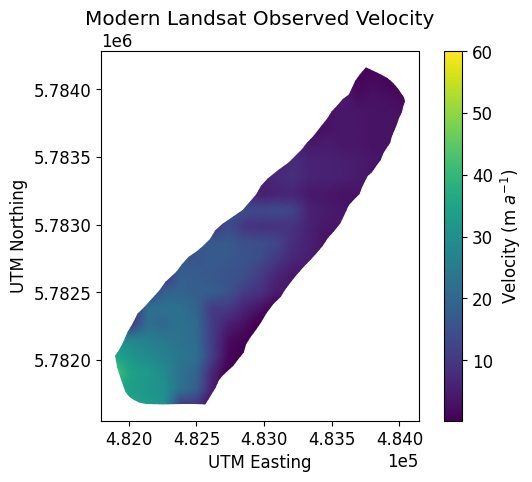

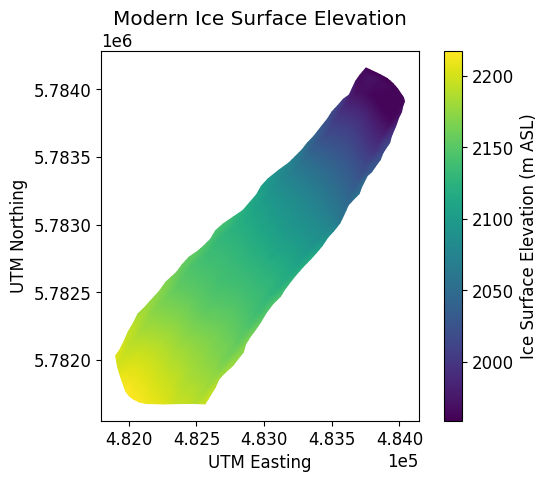

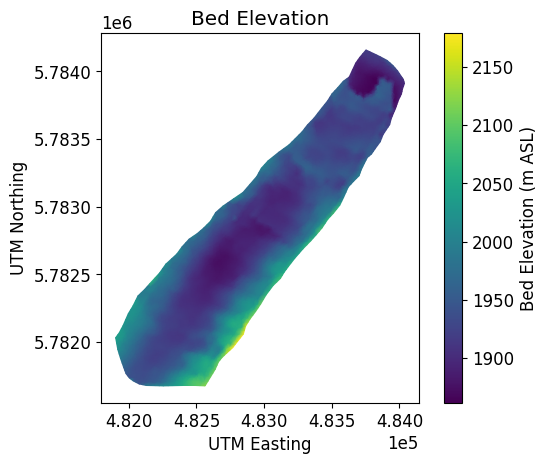

In [7]:

#set up function space and vector function space as shown in Beardmore and Hybrid xyz tutorials
Q = firedrake.FunctionSpace(mesh, family="CG", degree=2, vfamily="R", vdegree=0)
V = firedrake.VectorFunctionSpace(mesh,"CG", 2, dim=2, vfamily="GL", vdegree=2)

#use this to calculate a map view driving stress (otherwise dimenesions below don't work)
#V = firedrake.VectorFunctionSpace(mesh,"CG", 2, vfamily="GL", vdegree=2)
V2 = firedrake.VectorFunctionSpace(mesh, family="CG", degree=2, dim=3, vfamily="R", vdegree=0)


from icepack.constants import (
    ice_density as ρ_I,
    water_density as ρ_W,
    weertman_sliding_law as m,
    gravity as g,
)

x, y, ζ = firedrake.SpatialCoordinate(mesh)


#interpolate thickness and DEM to the 2D mesh footprint grid only
h0 = icepack.interpolate(thickness_file, Q)
s0 = icepack.interpolate(DEM_mod_file, Q)
b0 = icepack.interpolate(s0-h0, Q)

#create a vz_file so that the dimensions match up in strain calculation


#interpolate the vx/vy vectors onto extruded vector function space, as in Beardmore/Hybrid xyz tutorials
u_obs = icepack.interpolate((vx_file, vy_file), V)
#u_obs = icepack.interpolate((vx_file, vy_file, vz_file), V2)


#plot interpolated thickness and velocity to make sure they're sensible

#plot thickness
fig, axes = icepack.plot.subplots()
axes.set_title('Modern Ice Thickness')
colors = icepack.plot.tripcolor(h0, axes=axes)
fig.colorbar(colors,label="Ice Thickness (m)");
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure10.png',dpi=1500, facecolor='w', edgecolor='w',)

#plot landsat velocity
fig, axes = icepack.plot.subplots()
axes.set_title('Modern Landsat Observed Velocity')
colors = icepack.plot.tripcolor(u_obs, axes=axes, vmax=60)
fig.colorbar(colors,label="Velocity (m $a^{-1}$)");
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure11.png',dpi=1500, facecolor='w', edgecolor='w',)


#plot surface elevation
fig, axes = icepack.plot.subplots()
axes.set_title('Modern Ice Surface Elevation')
colors = icepack.plot.tripcolor(s0, axes=axes)
fig.colorbar(colors,label="Ice Surface Elevation (m ASL)");
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure12.png',dpi=1500, facecolor='w', edgecolor='w',)

#plot bed elevation
fig, axes = icepack.plot.subplots()
axes.set_title('Bed Elevation')
colors = icepack.plot.tripcolor(b0, axes=axes)
fig.colorbar(colors,label="Bed Elevation (m ASL)");
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure13.png',dpi=1500, facecolor='w', edgecolor='w',)




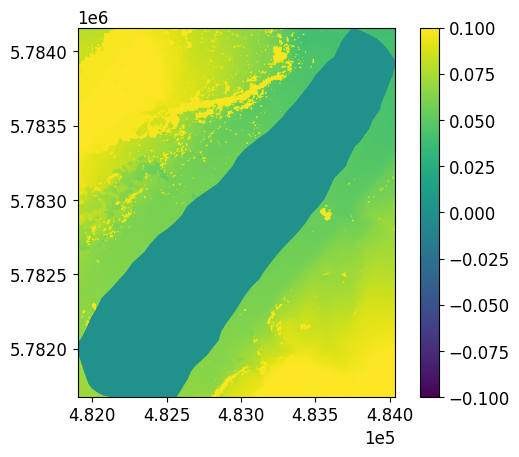

In [8]:
#create smoothed driving stress to 'guess' the initial friction coefficient
#modifying alpha here changes how smoothed the driving stress is
α = Constant(10e1)
τ = firedrake.Function(V2)

fig, axes = subplots()
colors = icepack.plot.tripcolor(τ, axes=axes)
fig.colorbar(colors);


τ_d = -ρ_I * g * h0 * grad(s0)
misfit = 0.5 * inner(τ - τ_d, τ - τ_d) * dx
smoothness = 0.5 * α ** 2 * inner(grad(τ), grad(τ)) * dx
J = misfit + smoothness
F = firedrake.derivative(J, τ)
firedrake.solve(F == 0, τ)

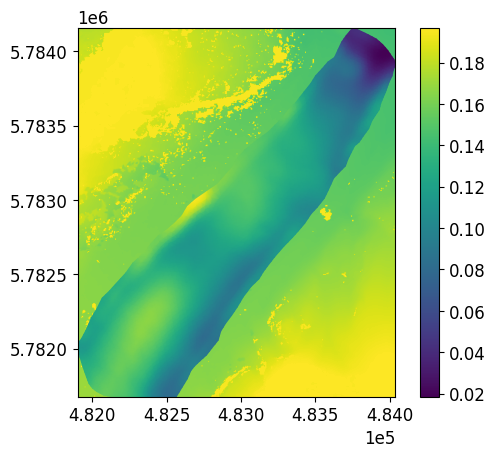

In [9]:
fig, axes = subplots()
colors = icepack.plot.tripcolor(τ, axes=axes)
fig.colorbar(colors);


85.23841872784968


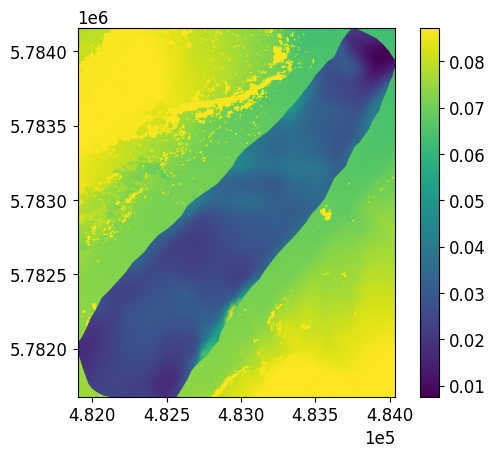

In [10]:

#Estimate fraction of the driving stress that the basal friction takes up, here 0.5 or 50%
fraction = Constant(0.5)
expr = fraction * sqrt(inner(τ, τ)) / sqrt(inner(u_obs, u_obs)) ** (1 / m)
C = firedrake.interpolate(expr, Q)
area = firedrake.assemble(Constant(1.0) * dx(mesh))
C_0 = Constant(firedrake.assemble(C * dx) / area)

fig, axes = subplots()
colors = icepack.plot.tripcolor(C, axes=axes)
fig.colorbar(colors);


#Set temperature to determine rate factor,A,used; from Icepack source code
T = Constant(270.4)
A = icepack.rate_factor(T)

#just to see/print what rate factor A is being used
T_test = 270.4
A_test = icepack.rate_factor(T_test)

print(A_test)


In [11]:



#define a Weertman type friction law
def friction(**kwargs):
    u = kwargs["velocity"]
    h = kwargs["thickness"]
    s = kwargs["surface"]
    #C = kwargs["friction"]
    θ = kwargs["log_friction"]
    C = C_0 * firedrake.exp(θ)

    p_W = ρ_W * g * firedrake.max_value(0, h - s)
    p_I = ρ_I * g * h
    ϕ = 1 - p_W / p_I
    
    return icepack.models.hybrid.bed_friction(
        velocity=u,
        friction=C * ϕ,
    )

In [12]:
model = icepack.models.HybridModel(friction=friction)
opts = {
    "dirichlet_ids": [1,3],
    "side_wall_ids": [2, 4],
    "diagnostic_solver_type": "petsc",
    "diagnostic_solver_parameters": {
        "snes_type": "newtontr",
        "ksp_type": "gmres",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}
solver = icepack.solvers.FlowSolver(model, **opts)


In [13]:
θ = firedrake.Function(Q)


In [14]:
u = solver.diagnostic_solve(
    velocity=u_obs,
    thickness=h0,
    surface=s0,
    fluidity=A,
    #friction=C,
    log_friction=θ,
)


import sympy
from firedrake import inner, outer, sqrt, dx, ds_b, ds_v
from icepack.calculus import grad, sym_grad, trace, Identity, FacetNormal, get_mesh_axes
from icepack.constants import (
    ice_density as ρ_I,
    water_density as ρ_W,
    glen_flow_law as n,
    gravity as g,
    strain_rate_min,)




                


In [15]:
def simulation(θ):
#def simulation(C):
    return solver.diagnostic_solve(
        velocity=u_obs,
        thickness=h0,
        surface=s0,
        fluidity=A,
        #friction=C,
        log_friction=θ,
    )

σx = Constant(2.0)
σy = Constant(2.0)
def loss_functional(u):
    δu = u - u_obs
    return 0.5 / Constant(area) * ((δu[0] / σx)**2 + (δu[1] / σy)**2) * dx

#set the value used in regularization function below
L = Constant(100)


def regularization(θ):
    return 0.5 * L**2 / Constant(area) * inner(grad(θ), grad(θ)) * dx



In [16]:
from icepack.statistics import StatisticsProblem, MaximumProbabilityEstimator

problem = StatisticsProblem(
    simulation=simulation,
    loss_functional=loss_functional,
    regularization=regularization,
    #controls=C,
    controls=θ,
)

In [17]:
estimator = MaximumProbabilityEstimator(
    problem,
    gradient_tolerance=1e-3,
    step_tolerance=1e-1,
    max_iterations=30,
)
#C = estimator.solve()
θ = estimator.solve()




Truncated CG Trust-Region Solver
  iter  value          gnorm          snorm          delta          #fval     #grad     tr_flag   iterCG    flagCG    
  0     4.665844e+01   9.702372e-02                  3.990587e+02   
  1     2.348305e+01   3.319762e-02   3.990587e+02   9.976468e+02   3         2         0         2         3         
  2     1.926655e+01   2.378415e-02   9.976468e+02   9.976468e+02   4         3         0         6         2         
  3     1.521578e+01   1.483969e-02   9.976468e+02   9.976468e+02   5         4         0         8         3         
  4     1.342770e+01   2.129502e-03   6.451813e+02   2.494117e+03   6         5         0         20        1         
  5     1.317011e+01   8.075845e-04   3.451252e+02   6.235293e+03   7         6         0         20        1         
Optimization Terminated with Status: Converged


13.111956254317054
0.05815052208507581
20.975246541702504


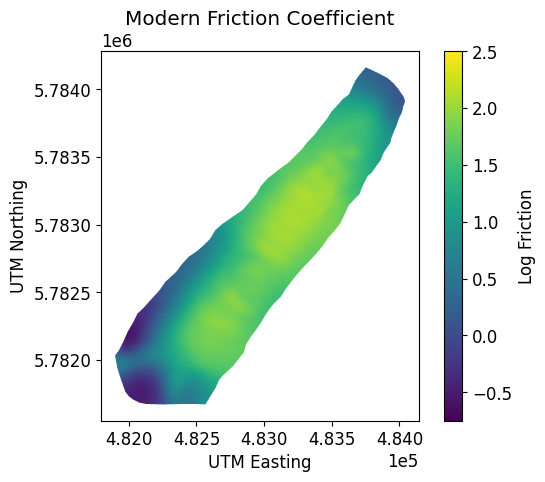

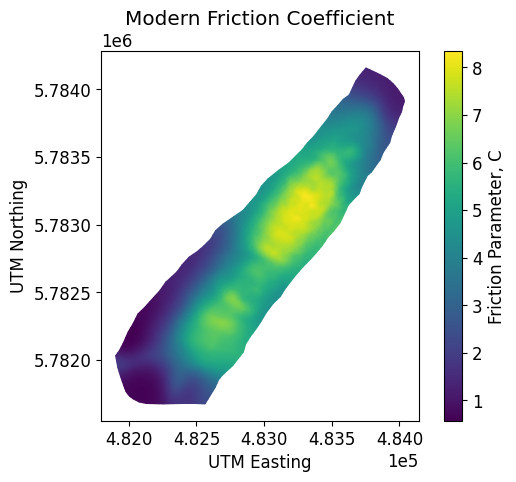

In [18]:
from firedrake import assemble, Constant, inner, grad, dx

#get velocity solution from converged friction inversion
u_inverse = simulation(θ)

#Get coordinates of mesh
points = mesh.coordinates.dat.data

#slice the list to get only z-values equal to 1
points = points[1::2]


fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(θ, vmin= -.75, vmax = 2.5, axes=axes)
fig.colorbar(
    colors, orientation="vertical", label="Log Friction"
)
axes.set_title('Modern Friction Coefficient');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure16.png',dpi=1500, facecolor='w', edgecolor='w',)

#convert back to friction parameter, C; from Beardmore script
#C = firedrake.interpolate(C_0 * firedrake.exp(θ), Q)
C = firedrake.interpolate(firedrake.exp(θ), Q)
#C = firedrake.Function(Q)

fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(C,axes=axes)
fig.colorbar(
    colors, orientation="vertical", label="Friction Parameter, C"
)
axes.set_title('Modern Friction Coefficient');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure16.png',dpi=1500, facecolor='w', edgecolor='w',)

#extract Friction coefficient data values as numpy array at those coordinates
Mod_C= np.array(C.at(points, tolerance=1e-10))

#save velocity solution at those points to csv file
np.savetxt("ModernFriction.csv", Mod_C,
              delimiter = ",")

#calculate model norm
def modnorm(θ):
    return inner(grad(θ), grad(θ)) * dx

#print model/data misfit and regularization for L-curve plots; L=10, T=270K
print(assemble(loss_functional(u_inverse)))
print(assemble(regularization(θ)))
print(assemble(modnorm(θ)))


#filename = "modern_state.h5"
#with firedrake.CheckpointFile(filename, "w") as chk:
 #   chk.save_function(C, name="friction")
  #  chk.save_function(u, name="velocity")

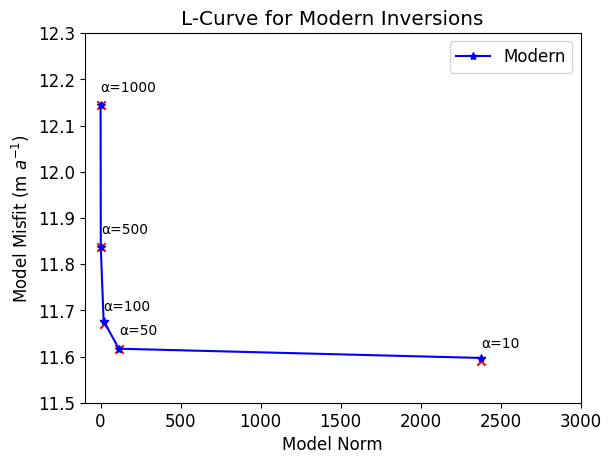

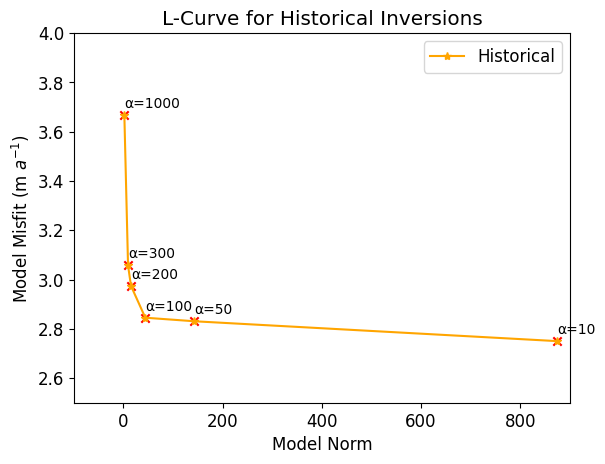

In [19]:
#plot L-curve

model_misfit = [12.1438, 11.83599, 11.67674, 11.6169, 11.59692]

model_norm = [0.5415, 1.80275, 19.47122, 115.10621, 2378.26331]


#12-21-2023 L-Curve for L = 1000, 300, 200, 100,50,10
hist_model_misfit = [3.669,3.057,2.974, 2.845,2.8306,2.75]
hist_model_norm = [1.736,9.20,15.183, 44.03,142.863,874.26]

fig, axes = plt.subplots()
axes.plot(model_norm, model_misfit, '-*',color="blue")
#axes.plot(hist_model_norm, hist_model_misfit, '-*')
axes.set_xlabel('Model Norm')
axes.set_ylabel('Model Misfit (m $a^{-1}$)');
axes.set_title('L-Curve for Modern Inversions');
ax = plt.gca()
ax.set_xlim([-100, 3000])
ax.set_ylim([11.5, 12.3])
#plt.savefig('/Users/davidpolashenski/Desktop/Figure15.png',dpi=1500, facecolor='w', edgecolor='w',)

def plot_embeddings(M_reduced, word2Ind, words):
    """ 
        Plot in a scatterplot the embeddings of the words specified in the list "words".
        Include a label next to each point.
    """
    for word in words:
        x, y = M_reduced[word2Ind[word]]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x+.03, y+.03, word, fontsize=10)
    #plt.show()

modern_misfit = np.array([[0.5415, 12.1438], [1.80275, 11.83599], [19.47, 11.67], [115.10621, 11.6169],  [2378,11.59]])
historic_misfit = np.array([[1.736,3.669], [9.20,3.057], [15.183,2.974], [44.03,2.845], [142.863,2.8306], [874.26,2.75]])
word2Ind_plot_test = {'⍺=1000': 0, '⍺=500': 1, '⍺=100': 2, '⍺=50': 3, '⍺=10': 4}
words = ['⍺=1000', '⍺=500', '⍺=100', '⍺=50', '⍺=10']
word2Ind_plot_test2 = {'⍺=1000': 0, '⍺=300': 1, '⍺=200': 2, '⍺=100': 3, '⍺=50': 4,'⍺=10': 5}
words2 = ['⍺=1000', '⍺=300', '⍺=200', '⍺=100','⍺=50','⍺=10']



plot_embeddings(modern_misfit, word2Ind_plot_test, words)
#plot_embeddings(historic_misfit, word2Ind_plot_test2, words2)
plt.legend(['Modern'])
plt.savefig('/Users/davidpolashenski/Desktop/Figure15.png',dpi=1500, facecolor='w', edgecolor='w',)


fig, axes = plt.subplots()
axes.plot(hist_model_norm, hist_model_misfit, '-*', color="orange")
axes.set_xlabel('Model Norm')
axes.set_ylabel('Model Misfit (m $a^{-1}$)');
axes.set_title('L-Curve for Historical Inversions');
ax = plt.gca()
ax.set_xlim([-100, 900])
ax.set_ylim([2.5, 4])
plot_embeddings(historic_misfit, word2Ind_plot_test2, words2)
plt.legend(['Historical'])
plt.savefig('/Users/davidpolashenski/Desktop/Figure16.png',dpi=1500, facecolor='w', edgecolor='w',)

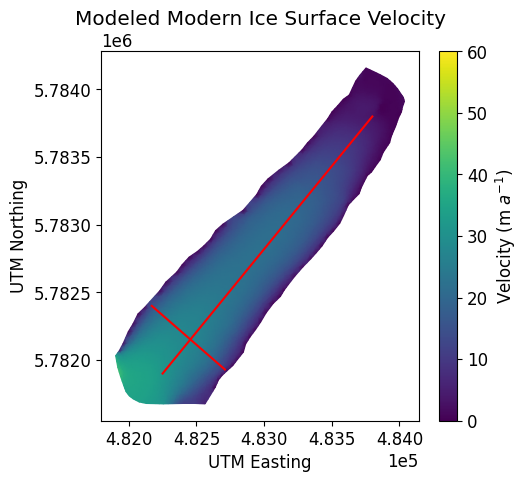

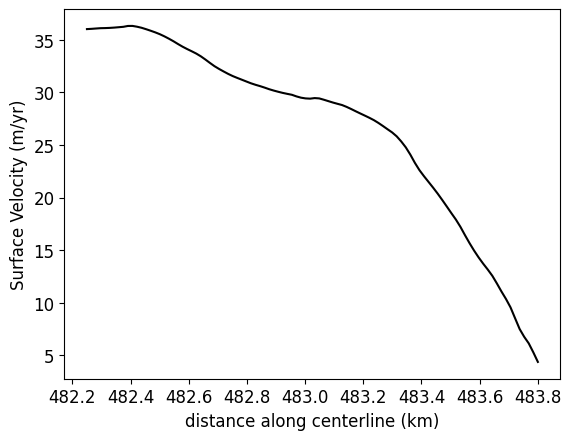

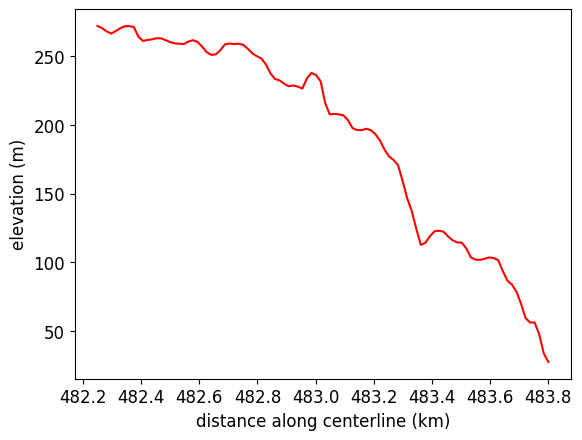

In [20]:
u_inverse = simulation(θ)


#for z, 1 is the surface and 0 is the bed
#set up centerline transect
x = np.linspace(4.8225e5,4.838e5,100)
y = np.linspace(5.7819e6,5.7838e6,100)
z = np.linspace(1,1,100)

#pair the x, y corrdinates into single array
xs = np.zeros((len(x), 3))
xs[:,0] = x
xs[:,1] = y
xs[:,2] = z


#Raymond cross section
x2 = np.linspace(4.8217e5,4.8271e5,100)
y2 = np.linspace(5.7824e6,5.78193e6,100)
z2 = np.linspace(1,1,100)

xs2 = np.zeros((len(x2), 3))
xs2[:,0] = x2
xs2[:,1] = y2
xs2[:,2] = z2

#plot transect over mesh grid
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(u_inverse,vmin= 0, vmax = 60,axes=axes)
axes.plot(x,y, color='red')
axes.plot(x2,y2, color='red')
fig.colorbar(colors, label="Velocity (m $a^{-1}$)", ax=axes, fraction=.1, pad=0.04);
axes.set_title('Modeled Modern Ice Surface Velocity');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure21.png',dpi=1500, facecolor='w', edgecolor='w',)
    
#This is syntax to access modeled value for any grid point within the mesh domain
#check = s([4.8255e5,5.7825e6])
#print(check)

#stored as vx, vy in two columns
u_inv = np.array(u_inverse.at(xs, tolerance=1e-10))
#convert to velocity magnitude
#test = ((plot_shear[:,0])**2)
u_inv_mag = (((u_inv[:,0])**2) + ((u_inv[:,1])**2))**0.5
#hs = np.array(h.at(xs, tolerance=1e-10))
#bs = np.array(b.at(xs, tolerance=1e-10))
#us = np.array(u.at(xs, tolerance=1e-10))

u_inv2 = np.array(u_inverse.at(xs2, tolerance=1e-10))
#convert to velocity magnitude
#test = ((plot_shear[:,0])**2)
u_inv_mag2 = (((u_inv2[:,0])**2) + ((u_inv2[:,1])**2))**0.5


#Plot surface elevation and basal elevation along centerline transect
fig, axes = plt.subplots()
axes.plot(xs[:, 0] / 1e3, u_inv_mag, color='black')
#axes.plot(xs[:, 0] / 1e3, u_inv, color='blue')

axes.set_xlabel('distance along centerline (km)')
axes.set_ylabel('Surface Velocity (m/yr)');

hs = np.array(h0.at(xs, tolerance=1e-10))

fig, axes = plt.subplots()
axes.plot(xs[:, 0] / 1e3, hs, color='red')
axes.set_xlabel('distance along centerline (km)')
axes.set_ylabel('elevation (m)');

1318
[[4.82077177e+05 5.78168906e+06 0.00000000e+00]
 [4.82077177e+05 5.78168906e+06 1.00000000e+00]
 [4.82032261e+05 5.78171233e+06 0.00000000e+00]
 ...
 [4.84037981e+05 5.78391150e+06 1.00000000e+00]
 [4.84023568e+05 5.78387047e+06 0.00000000e+00]
 [4.84023568e+05 5.78387047e+06 1.00000000e+00]]
659
[[4.82077177e+05 5.78168906e+06 1.00000000e+00]
 [4.82032261e+05 5.78171233e+06 1.00000000e+00]
 [4.82069314e+05 5.78173496e+06 1.00000000e+00]
 ...
 [4.83998067e+05 5.78389175e+06 1.00000000e+00]
 [4.84037981e+05 5.78391150e+06 1.00000000e+00]
 [4.84023568e+05 5.78387047e+06 1.00000000e+00]]
659
[[ 482077.177062   5781689.060271  ]
 [ 482032.261193   5781712.329161  ]
 [ 482069.31408281 5781734.96198375]
 ...
 [ 483998.06698943 5783891.75471634]
 [ 484037.980873   5783911.495733  ]
 [ 484023.567974   5783870.474407  ]]


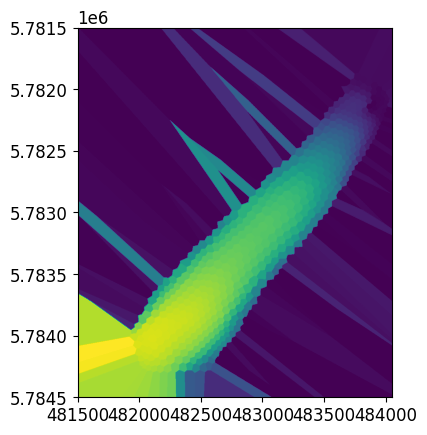

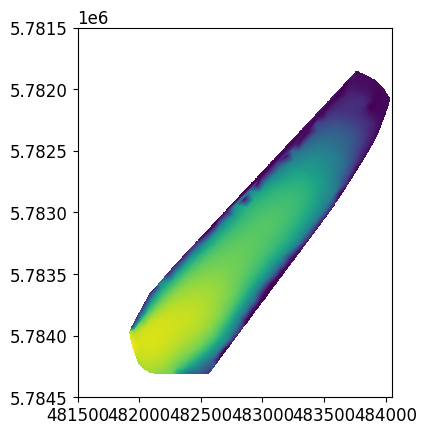

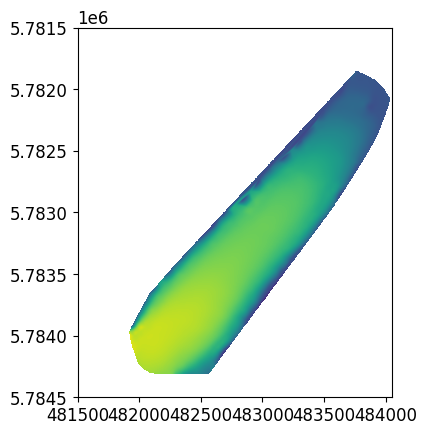

In [21]:
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

#Get coordinates of mesh
points = mesh.coordinates.dat.data

print(len(points))

print(points)

#slice the list to get only z-values equal to 1
points = points[1::2]
print(len(points))

print(points)

# save coordinate array into csv file
np.savetxt("ModernMeshSamplePoints.csv", points,
              delimiter = ",")



#extract data values as numpy array at those coordinates
u_inv2 = np.array(u_inverse.at(points, tolerance=1e-10))
u_inv_mag2 = (((u_inv2[:,0])**2) + ((u_inv2[:,1])**2))**0.5

#save velocity solution at those points to csv file
np.savetxt("ModernSurfaceVelocity.csv", u_inv_mag2,
              delimiter = ",")

#fig, axes = plt.subplots()
#axes.plot(test, u_inv_mag, color='black')
#axes.plot(xs[:, 0] / 1e3, u_inv, color='blue')

print(len(u_inv_mag2))


#get only the map view points for interpolant functions
points = points[:,:2]
print(points)

#using a scattered interpolant on defined grid 
grid_x, grid_y = np.meshgrid(np.linspace(4.815e5,4.8405e5,1000),
                             np.linspace(5.7845e6,5.7815e6,1000), indexing='ij')

grid_z0 = griddata(points, u_inv_mag2, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, u_inv_mag2, (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, u_inv_mag2, (grid_x, grid_y), method='cubic') 

fig, ax = plt.subplots()
plt.imshow(grid_z0.T, extent=(4.815e5,4.8405e5,5.7845e6,5.7815e6)) 

fig, ax = plt.subplots()
plt.imshow(grid_z1.T, extent=(4.815e5,4.8405e5,5.7845e6,5.7815e6)) 

fig, ax = plt.subplots()
plt.imshow(grid_z2.T, extent=(4.815e5,4.8405e5,5.7845e6,5.7815e6)) 



[[4.82077177e+05 5.78168906e+06 0.00000000e+00]
 [4.82077177e+05 5.78168906e+06 1.00000000e+00]
 [4.82032261e+05 5.78171233e+06 0.00000000e+00]
 ...
 [4.84037981e+05 5.78391150e+06 1.00000000e+00]
 [4.84023568e+05 5.78387047e+06 0.00000000e+00]
 [4.84023568e+05 5.78387047e+06 1.00000000e+00]]
[[4.82077177e+05 5.78168906e+06 1.00000000e+00]
 [4.82032261e+05 5.78171233e+06 1.00000000e+00]
 [4.82069314e+05 5.78173496e+06 1.00000000e+00]
 ...
 [4.83998067e+05 5.78389175e+06 1.00000000e+00]
 [4.84037981e+05 5.78391150e+06 1.00000000e+00]
 [4.84023568e+05 5.78387047e+06 1.00000000e+00]]


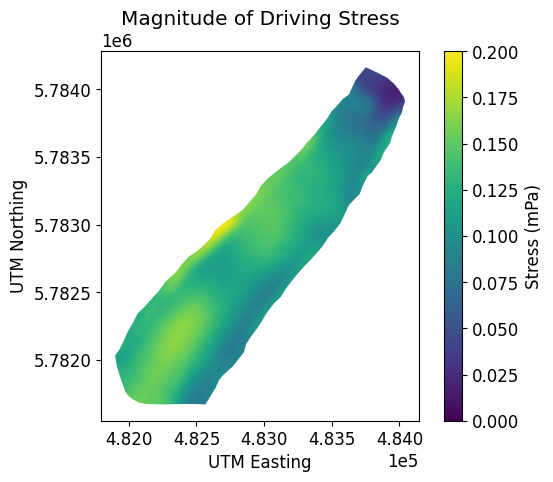

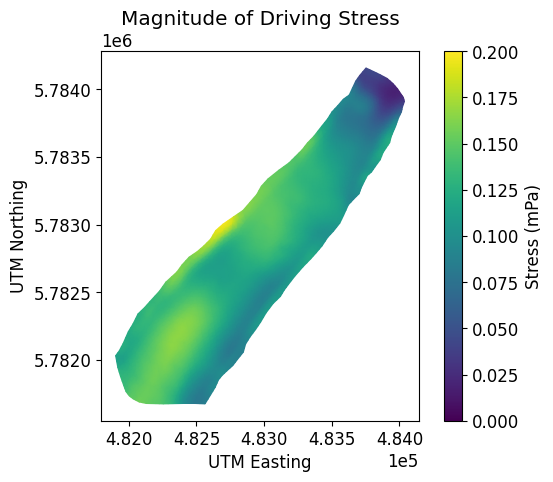

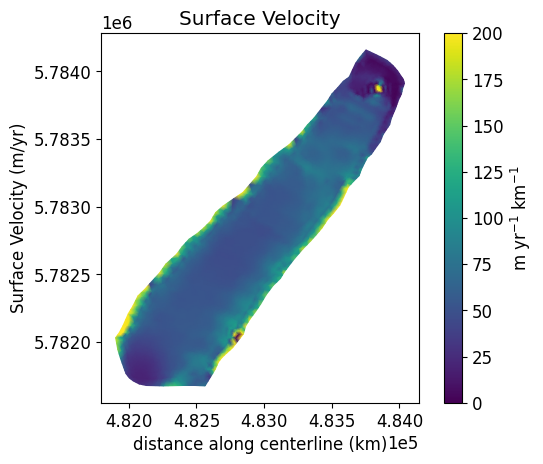

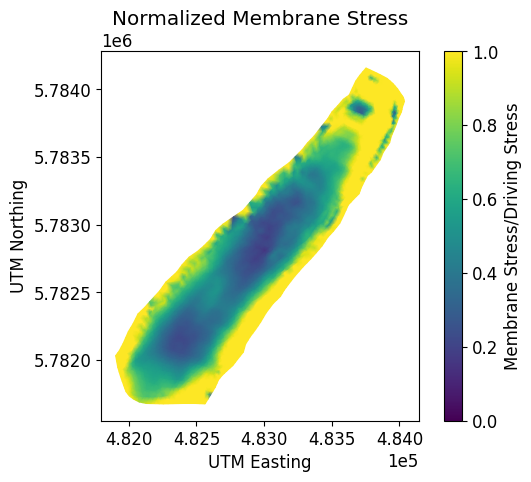

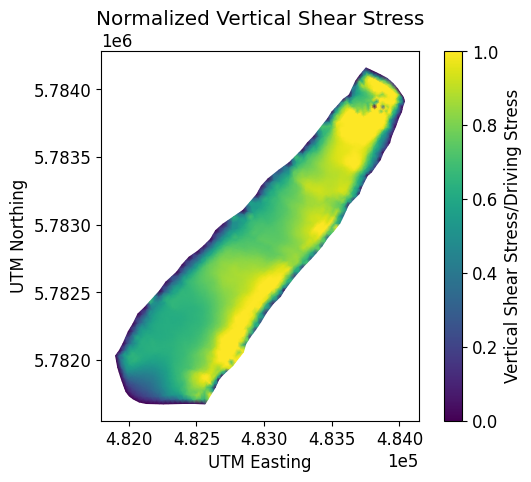

In [22]:
import sympy
from firedrake import inner, outer, sqrt, dx, ds_b, ds_v
from icepack.calculus import grad, sym_grad, trace, Identity, FacetNormal, get_mesh_axes
from icepack.constants import (
    ice_density as ρ_I,
    water_density as ρ_W,
    glen_flow_law as n,
    gravity as g,
    strain_rate_min,)


#make function from hybrid source code to calculate the strain rates and stresses
def horizontal_strain_rate(u, s, h):
    r"""Calculate the horizontal strain rate with corrections for terrain-
    following coordinates"""
    mesh = u.ufl_domain()
    dim = mesh.geometric_dimension()
    ζ = firedrake.SpatialCoordinate(mesh)[dim - 1]
    b = s - h
    v = -((1 - ζ) * grad(b) + ζ * grad(s)) / h
    du_dζ = u.dx(dim - 1)
    return sym_grad(u) + 0.5 * (outer(du_dζ, v) + outer(v, du_dζ))


def vertical_strain_rate(u, h):
    r"""Calculate the vertical strain rate with corrections for terrain-
    following coordinates"""
    mesh = u.ufl_domain()
    du_dζ = u.dx(mesh.geometric_dimension() - 1)
    return 0.5 * du_dζ / h

def _effective_strain_rate(ε_x, ε_z, ε_min):
    return sqrt((inner(ε_x, ε_x) + trace(ε_x) ** 2 + inner(ε_z, ε_z) + ε_min**2) / 2)

def membrane_stress(ε_x, ε_z, ε_e, A):
    r"""Calculate the membrane and vertical shear stresses for the given
    horizontal and shear strain rates and fluidity"""
    ε_min = firedrake.Constant(strain_rate_min)
    μ = 0.5 * A ** (-1 / n) * ε_e ** (1 / n - 1)
    I = Identity(ε_x.ufl_domain().geometric_dimension() - 1)
    return 2 * μ * (ε_x + trace(ε_x) * I)


def vertical_stress(ε_x, ε_z, ε_e, A):
    r"""Calculate the membrane and vertical shear stresses for the given
    horizontal and shear strain rates and fluidity"""
    ε_min = firedrake.Constant(strain_rate_min)
    μ = 0.5 * A ** (-1 / n) * ε_e ** (1 / n - 1)
    I = Identity(ε_x.ufl_domain().geometric_dimension() - 1)
    return 2 * μ * ε_z


def stress_mag(stress):
    return sqrt((inner(stress, stress)))

ε_x_inv = horizontal_strain_rate(u_inverse, h0, s0)

ε_z_inv = vertical_strain_rate(u_inverse, h0)

ε_e_inv = _effective_strain_rate(ε_x_inv, ε_z_inv, strain_rate_min)

ε_e_inv_plot = firedrake.project(1e3*ε_e_inv, Q)

membrane_inv = membrane_stress(ε_x_inv, ε_z_inv, ε_e_inv, A)

shear_inv = vertical_stress(ε_x_inv, ε_z_inv, ε_e_inv, A)



#calculate the magnitude of stresses
membrane_inv_mag = stress_mag(membrane_inv)
shear_inv_mag = stress_mag(shear_inv)
driving_mag = stress_mag(τ)


#normalize membrane/vertical shear stress by magnitude of driving stress 
norm_membrane_inv = membrane_inv_mag/driving_mag
norm_shear_inv = shear_inv_mag/driving_mag

#project calculated stress solution back onto Function space, Q, for plotting in Icepack                 
norm_membrane_inv_plot = firedrake.project(norm_membrane_inv,Q)
norm_shear_inv_plot = firedrake.project(norm_shear_inv, Q)
driving_plot = firedrake.project(driving_mag,Q)
                
    
#Get coordinates of mesh
points = mesh.coordinates.dat.data
print(points)

#slice the list to get only z-values equal to 1
points = points[1::2]


print(points)

#here the mesh is only 2D so give it points list that has only x/y UTM coordinates, not z as above
#points = points[:,:2]
#print(points)

#save solutions to driving stress/membrane stress/etc. to make change plots
#extract data values as numpy array at those coordinates
ModDriveStress = np.array(driving_plot.at(points, tolerance=1e-10))

#save velocity solution at those points to csv file
np.savetxt("ModernDrivingStress.csv",ModDriveStress,
              delimiter = ",")


#extract data values as numpy array at those coordinates
ModMembraneStress = np.array(norm_membrane_inv_plot.at(points, tolerance=1e-10))


#save velocity solution at those points to csv file
np.savetxt("ModernMembraneStress.csv",ModMembraneStress,
              delimiter = ",")

#extract data values as numpy array at those coordinates
ModShearStress = np.array(norm_shear_inv_plot.at(points, tolerance=1e-10))


#save velocity solution at those points to csv file
np.savetxt("ModernShearStress.csv",ModShearStress,
              delimiter = ",")




#driving stress
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(τ,vmin = 0, vmax =0.2, axes=axes)
fig.colorbar(
    colors, orientation="vertical", label="Stress (mPa)"
)
axes.set_title('Magnitude of Driving Stress');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure20.png',dpi=1500, facecolor='w', edgecolor='w',)

fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(driving_plot,vmin = 0, vmax =0.2, axes=axes)
fig.colorbar(
    colors, orientation="vertical", label="Stress (mPa)"
)
axes.set_title('Magnitude of Driving Stress');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure20.png',dpi=1500, facecolor='w', edgecolor='w',)


fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(ε_e_inv_plot,vmin = 0, vmax =200, axes=axes)
fig.colorbar(
    colors, orientation="vertical", label="m yr${}^{-1}$ km${}^{-1}$"
)
axes.set_title('Surface Velocity');
axes.set_xlabel('distance along centerline (km)')
axes.set_ylabel('Surface Velocity (m/yr)');


fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(norm_membrane_inv_plot,vmin = 0, vmax =1, axes=axes)
fig.colorbar(
    colors, orientation="vertical", label="Membrane Stress/Driving Stress"
)
axes.set_title('Normalized Membrane Stress');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure17.png',dpi=1500, facecolor='w', edgecolor='w',)


fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(norm_shear_inv_plot,vmin = 0, vmax =1, axes=axes)
fig.colorbar(
    colors, orientation="vertical", label="Vertical Shear Stress/Driving Stress"
)
axes.set_title('Normalized Vertical Shear Stress');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure18.png',dpi=1500, facecolor='w', edgecolor='w',)


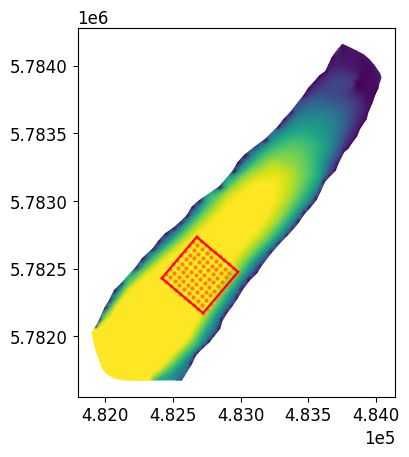

In [23]:
#uppermost corner coordinates (400 by 400 m square)
e1 = 4.82418e5
e2 = 4.82676e5
e3 = 4.82982e5
e4 = 4.82723e5


n1 = 5.782430e6
n2 = 5.782735e6
n3 = 5.782477e6
n4 = 5.782172e6

#200 m down glacier 
#e1 = 4.82547e5
#e2 = 4.82806e5
#e3 = 4.83111e5
#e4 = 4.82853e5


#n1 = 5.782582e6
#n2 = 5.782888e6
#n3 = 5.782629e6
#n4 = 5.782324e6

#200m down glacier 
#e1 = 4.82676e5
#e2 = 4.82935e5
#e3 = 4.83240e5
#e4 = 4.82982e5


#n1 = 5.782735e6
#n2 = 5.783040e6
#n3 = 5.782782e6
#n4 = 5.782477e6

#200m down glacier 
#e1 = 4.82805e5
#e2 = 4.83064e5
#e3 = 4.83369e5
#e4 = 4.83111e5


#n1 = 5.782888e6
#n2 = 5.783193e6
#n3 = 5.782935e6
#n4 = 5.782629e6

#lowest box
#e1 = 4.82935e5
#e2 = 4.83193e5
#e3 = 4.83489e5
#e4 = 4.83240e5


#n1 = 5.783041e6
#n2 = 5.783347e6
#n3 = 5.783088e6
#n4 = 5.782782e6




#side1
x1 = np.linspace(e1,e2,100)
y1 = np.linspace(n1,n2,100)

#side2
x2 = np.linspace(e2,e3,100)
y2 = np.linspace(n2,n3,100)

#side3
x3 = np.linspace(e3,e4,100)
y3 = np.linspace(n3,n4,100)

#side3
x3 = np.linspace(e3,e4,100)
y3 = np.linspace(n3,n4,100)

#side4
x4 = np.linspace(e4,e1,100)
y4 = np.linspace(n4,n1,100)


#sampling equations for driving stress
t = np.linspace(0,1,10)
s = np.linspace(0,1,10)

x_line =np.zeros(len(t)*len(s))
y_line =np.zeros(len(t)*len(s))

#formula of lines
for i in range(len(t)):
    for j in range(len(s)):
        x_line[j+(i*len(s))] = e1 + t[i]*(e4-e1) + s[j]*(e2-e1)
        y_line[j+(i*len(s))] = n1 + t[i]*(n4-n1) + s[j]*(n2-n1)
    


#print(x_line)
#print(y_line)

#np.vstack((tp, fp)).T
sample_points = np.vstack((x_line,y_line)).T


#print(test_points)



#plot transect over mesh grid
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(u_inverse, vmin=0, vmax=20,axes=axes)
axes.scatter(sample_points[:,0], sample_points[:,1], 4.0, "tab:orange");
axes.plot(x1,y1, color='red')
axes.plot(x2,y2, color='red')
axes.plot(x3,y3, color='red')
axes.plot(x4,y4, color='red')

In [24]:

#create a vertex only mesh from repeating list of gridded coordinates,p
#'warn' missing points is supposed to remove those coordinates not within mesh domain
vom = firedrake.VertexOnlyMesh(mesh2d, sample_points, missing_points_behaviour="warn")
#P0DG = FunctionSpace(vom, "DG", 0)

#Get coordinates of mesh that should still be regularly spaced, but with points outside mesh removed
sample_points2 = vom.coordinates.dat.data

#now that you've gotten coordinates from inside vom, append 1 back to z-coordinate for sampling stress solutions
sample_points2 = np.append(sample_points2, np.ones([len(sample_points),1]), 1)
#print(sample_points)
print(len(sample_points2))


#sample driving stress at same points
τ_d_points = np.array(driving_plot.at(sample_points2, tolerance=1e-10))

print(τ_d_points)
mean_τ_d = np.mean(τ_d_points)
print(mean_τ_d)

100
[0.14462744 0.14129133 0.13686167 0.1311892  0.12502902 0.11926023
 0.11502967 0.11250406 0.11189939 0.11112886 0.15214838 0.14740891
 0.14173031 0.1352719  0.12837854 0.12257962 0.11752172 0.11365183
 0.11250647 0.11261193 0.15642784 0.15033009 0.14385103 0.13652374
 0.12932069 0.12348352 0.11781858 0.11345834 0.11360809 0.11483839
 0.15570279 0.14957159 0.14253498 0.13514063 0.12849419 0.12260193
 0.11772374 0.11541616 0.11499866 0.11573643 0.15132141 0.14567297
 0.13975293 0.13335219 0.12714809 0.12290577 0.11959525 0.1175966
 0.11685141 0.11693603 0.1444382  0.13966713 0.13493345 0.12995622
 0.12488097 0.12134176 0.11880183 0.11702328 0.11661332 0.11678562
 0.13485803 0.13157471 0.12789617 0.12344187 0.11983523 0.11700962
 0.11498604 0.11352792 0.11332138 0.11318385 0.12322746 0.12130659
 0.11824432 0.11475898 0.11221516 0.11031101 0.1086797  0.10744809
 0.10665008 0.10610914 0.10996073 0.10919076 0.10718465 0.10470527
 0.102961   0.10147035 0.10018346 0.09856398 0.0973697  0.0

In [25]:
#membrane_inv is four-component tensor so need to interpolate each component individually
#R_xy and R_yx are symmetric/equal
R_xx = firedrake.interpolate(membrane_inv[0,0],Q)
R_xy = firedrake.interpolate(membrane_inv[1,0],Q)
R_yx = firedrake.interpolate(membrane_inv[0,1],Q)
R_yy = firedrake.interpolate(membrane_inv[1,1],Q)

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
(2, 2)
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
(2, 2)
(100, 4)
[[-0.02654527  0.03321889  0.03321889 -0.03730038]
 [-0.02664496  0.03320863  0.03320863 -0.0375701 ]
 [-0.02674326  0.03320757  0.03320757 -0.03781596]
 [-0.02684018  0.03321573  0.03321573 -0.03803799]
 [-0.02693572  0.03323309  0.03323309 -0.03823616]
 [-0.02702988  0.03325966  0.03325966 -0.0384105 ]
 [-0.02712266  0.03329543  0.03329543 -0.03856098]
 [-0.02721405  0.03334042  0.03334042 -0.03868762]
 [-0.02730406  0.0333946   0.0333946  -0.03879042]
 [-0.02739269  0.033458    0.033458   -0.03886936]]
[[ 0 10]
 [10  0]]
(2, 2)
[[-9.99999997e+00 -2.79374445e-16]
 [ 2.79374445e-16  9.99999997e+00]]
[7.89307554 7.91785768 7.9442003  7.97212558 8.00165465 8.03280762
 8.06560354 8.10006043 8.13619526 8.17402398 8.20888295 8.23904213
 8.26714015 8.29316758 8.31711557 8.35418051 8.38893333 8.41731868
 8.43932109 8.45492951 8.4641372  8.46694185 8.46334549 8.

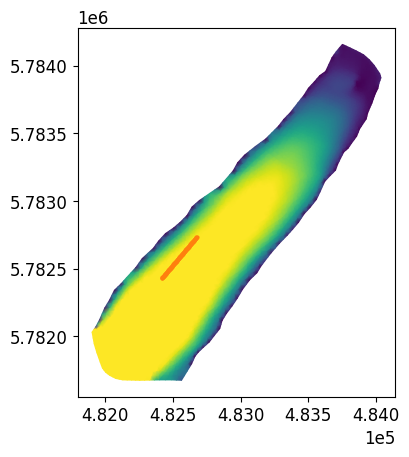

In [26]:
#side one solution 
side_one_points = np.vstack((x1,y1)).T

#plot transect over mesh grid
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(u_inverse, vmin=0, vmax=20,axes=axes)
axes.scatter(side_one_points[:,0], side_one_points[:,1], 4.0, "tab:orange");

#create a vertex only mesh from repeating list of gridded coordinates,p
#'warn' missing points is supposed to remove those coordinates not within mesh domain
vom = firedrake.VertexOnlyMesh(mesh2d, side_one_points, missing_points_behaviour="warn")
#P0DG = FunctionSpace(vom, "DG", 0)

#Get coordinates of mesh that should still be regularly spaced, but with points outside mesh removed
side_one_points = vom.coordinates.dat.data

#now that you've gotten coordinates from inside vom, append 1 back to z-coordinate for sampling stress solutions
side_one_points = np.append(side_one_points, np.ones([len(side_one_points),1]), 1)

#sample along side 1 (lateral R_xy)
R_xx_points = np.array(R_xx.at(side_one_points, tolerance=1e-10))
R_xy_points = np.array(R_xy.at(side_one_points, tolerance=1e-10))
R_yx_points = np.array(R_yx.at(side_one_points, tolerance=1e-10))
R_yy_points = np.array(R_yy.at(side_one_points, tolerance=1e-10))

#sample ice thickness at same points
h_points = np.array(h0.at(side_one_points, tolerance=1e-10))



#print(R_xy_points)
#print(R_yx_points)
#print(len(R_yx_points))

#rotation matrix; can't get variable names to give 2by2 matrix; gives 2by2by1 which doesn't work
rot1 = np.array([[0.70710678, -0.70710678], [0.70710678, 0.70710678]])
#rot1 = np.array([[theta1, theta2], [theta3, theta4]]) 
print(rot1)
print(rot1.shape)

#rot2 = np.array([[theta1, theta3], [theta2, theta4]]) 
rot2 = np.array([[0.70710678, 0.70710678], [-0.70710678, 0.70710678]])
print(rot2)
print(rot2.shape)


#initialize a n by 4 array for rotated points
rot_R = np.zeros((len(R_xy_points),4))
print(rot_R.shape)

#create loop to pull 4 components and rotate them for each point
for i in range(len(R_xx_points)):
    
    #put the first four components into a 2 by 2 matrix for rotattion calculation
    #stress_tensor = np.array([[R_xx_points[0], R_xy_points[0]], [R_yx_points[0], R_yy_points[0]]])
    stress_tensor = np.array([[R_xx_points[i], R_xy_points[i]], [R_yx_points[i], R_yy_points[i]]])
    #print(stress_tensor.shape)
    #print(i)
    
    #apply rotation matrices
    rot_stress = np.dot(rot1, stress_tensor) 
    rot_stress2 = np.dot(rot_stress, rot2)  
    
    rot_R[i,0] = rot_stress2[0,0]
    rot_R[i,1] = rot_stress2[0,1]
    rot_R[i,2] = rot_stress2[1,0]
    rot_R[i,3] = rot_stress2[1,1]
    

#print(stress_tensor.shape)  
#print(i)
#print part of the rotated solution
print(rot_R[0:10,:])

#example for 45 degree rotation; answer should 'swap' values with non-zero stress on diagonal (xx,yy)
stress_tensor_test = np.array([[0, 10,], [10, 0]])
print(stress_tensor_test)
print(stress_tensor_test.shape)

#apply rotation matrices
rot_stress = np.dot(rot1, stress_tensor_test) 
rot_stress2 = np.dot(rot_stress, rot2)  

#print(rot_stress)
print(rot_stress2)

#find the average H*R_xy value for side 1
side1_sol = (h_points*rot_R[:,1])
print(side1_sol)
#print(rot_R[:,1])
#print(rot_R[:,2])
#print(h_points)

#find average value
side1_sol_mean = np.mean(side1_sol)
print(side1_sol_mean)

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
(2, 2)
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
(2, 2)
(100, 4)
[[-0.0194822  -0.05368159 -0.05368159 -0.03289186]
 [-0.0207851  -0.05410484 -0.05410484 -0.03355814]
 [-0.02195055 -0.0544734  -0.0544734  -0.03421319]
 [-0.02297856 -0.05478729 -0.05478729 -0.03485703]
 [-0.02386912 -0.0550465  -0.0550465  -0.03548966]
 [-0.02462224 -0.05525103 -0.05525103 -0.03611106]
 [-0.02523791 -0.05540088 -0.05540088 -0.03672125]
 [-0.02571614 -0.05549605 -0.05549605 -0.03732023]
 [-0.02605691 -0.05553654 -0.05553654 -0.03790798]
 [-0.02626025 -0.05552236 -0.05552236 -0.03848453]]
[[ 0 10]
 [10  0]]
(2, 2)
[[-9.99999997e+00 -2.79374445e-16]
 [ 2.79374445e-16  9.99999997e+00]]
[-8.61463228 -8.69275191 -8.75547061 -8.80264052 -8.83415451 -8.8499462
 -8.84998996 -8.8343009  -8.80293487 -8.75598847 -8.69359904 -8.61594467
 -8.52324419 -8.41575718 -8.29378395 -8.24809644 -8.21631104 -8.19340133
 -8.17938946 -8.17430201 -8.17816998 -8.1

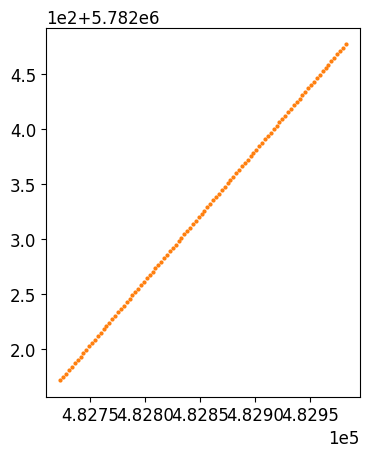

In [27]:
#side 3 solution 
side_three_points = np.vstack((x3,y3)).T

#plot transect over mesh grid
fig, axes = icepack.plot.subplots()
#colors = icepack.plot.tripcolor(u_shear, vmin=0, vmax=20,axes=axes)
axes.scatter(side_three_points[:,0], side_three_points[:,1], 4.0, "tab:orange");


#create a vertex only mesh from repeating list of gridded coordinates,p
#'warn' missing points is supposed to remove those coordinates not within mesh domain
vom = firedrake.VertexOnlyMesh(mesh2d, side_three_points, missing_points_behaviour="warn")
#P0DG = FunctionSpace(vom, "DG", 0)

#Get coordinates of mesh that should still be regularly spaced, but with points outside mesh removed
side_three_points = vom.coordinates.dat.data

#now that you've gotten coordinates from inside vom, append 1 back to z-coordinate for sampling stress solutions
side_three_points = np.append(side_three_points, np.ones([len(side_three_points),1]), 1)

#sample along side 1 (lateral R_xy)
R_xx_points = np.array(R_xx.at(side_three_points, tolerance=1e-10))
R_xy_points = np.array(R_xy.at(side_three_points, tolerance=1e-10))
R_yx_points = np.array(R_yx.at(side_three_points, tolerance=1e-10))
R_yy_points = np.array(R_yy.at(side_three_points, tolerance=1e-10))

#sample ice thickness at same points
h_points = np.array(h0.at(side_three_points, tolerance=1e-10))



#print(R_xy_points)
#print(R_yx_points)
#print(len(R_yx_points))

#rotation matrix; can't get variable names to give 2by2 matrix; gives 2by2by1 which doesn't work
rot1 = np.array([[0.70710678, -0.70710678], [0.70710678, 0.70710678]])
#rot1 = np.array([[theta1, theta2], [theta3, theta4]]) 
print(rot1)
print(rot1.shape)

#rot2 = np.array([[theta1, theta3], [theta2, theta4]]) 
rot2 = np.array([[0.70710678, 0.70710678], [-0.70710678, 0.70710678]])
print(rot2)
print(rot2.shape)

#put the first four components into a 2 by 2 matrix for rotattion calculation
#stress_tensor_test = np.array([[R_xx_points[2430], R_xy_points[2430]], [R_yx_points[2430], R_yy_points[2430]]])
#print(stress_tensor.shape)

#initialize a n by 4 array for rotated points
rot_R = np.zeros((len(R_xy_points),4))
print(rot_R.shape)

#create loop to pull 4 components and rotate them for each point
for i in range(len(R_xx_points)):
    
    #put the first four components into a 2 by 2 matrix for rotattion calculation
    #stress_tensor = np.array([[R_xx_points[0], R_xy_points[0]], [R_yx_points[0], R_yy_points[0]]])
    stress_tensor = np.array([[R_xx_points[i], R_xy_points[i]], [R_yx_points[i], R_yy_points[i]]])
    #print(stress_tensor.shape)
    #print(i)
    
    #apply rotation matrices
    rot_stress = np.dot(rot1, stress_tensor) 
    rot_stress2 = np.dot(rot_stress, rot2)  
    
    rot_R[i,0] = rot_stress2[0,0]
    rot_R[i,1] = rot_stress2[0,1]
    rot_R[i,2] = rot_stress2[1,0]
    rot_R[i,3] = rot_stress2[1,1]
    

#print(stress_tensor.shape)  
#print(i)
#print part of the rotated solution
print(rot_R[0:10,:])

#example for 45 degree rotation; answer should 'swap' values with non-zero stress on diagonal (xx,yy)
stress_tensor_test = np.array([[0, 10,], [10, 0]])
print(stress_tensor_test)
print(stress_tensor_test.shape)

#apply rotation matrices
rot_stress = np.dot(rot1, stress_tensor_test) 
rot_stress2 = np.dot(rot_stress, rot2)  

#print(rot_stress)
print(rot_stress2)

#find the average H*R_xy value for side 1
side3_sol = (h_points*rot_R[:,1])
print(side3_sol)
#print(rot_R[:,1])
#print(rot_R[:,2])
#print(h_points)

#find average value
side3_sol_mean = np.mean(side3_sol)
print(side3_sol_mean)

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
(2, 2)
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
(2, 2)
(100, 4)
[[-0.02100957  0.03898116  0.03898116 -0.01876986]
 [-0.02004121  0.0378248   0.0378248  -0.0186239 ]
 [-0.01914123  0.0366528   0.0366528  -0.01849818]
 [-0.01830963  0.03546516  0.03546516 -0.0183927 ]
 [-0.01754641  0.03426188  0.03426188 -0.01830746]
 [-0.01685157  0.03304296  0.03304296 -0.01824246]
 [-0.01622512  0.03180841  0.03180841 -0.0181977 ]
 [-0.01566705  0.03055821  0.03055821 -0.01817318]
 [-0.01517736  0.02929238  0.02929238 -0.0181689 ]
 [-0.01475739  0.02801239  0.02801239 -0.01818568]]
[[ 0 10]
 [10  0]]
(2, 2)
[[-9.99999997e+00 -2.79374445e-16]
 [ 2.79374445e-16  9.99999997e+00]]
[-5.06878714 -4.86228002 -4.6680446  -4.48659186 -4.31839439 -4.16388638
 -4.02346369 -3.89748376 -3.78626568 -3.69042164 -3.7215926  -3.76532809
 -3.82166092 -3.89060405 -3.97215061 -4.06627385 -4.17292718 -4.29204418
 -4.42305479 -4.53187976 -4.62786082 -4.

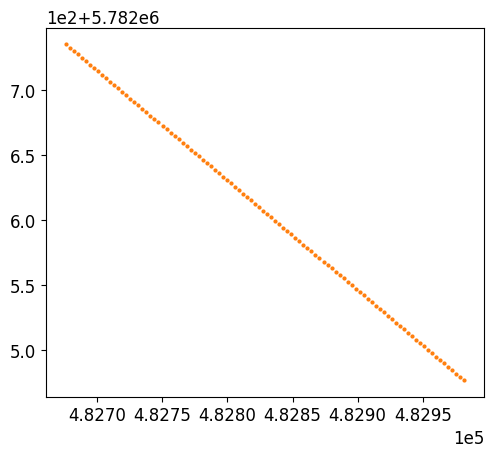

In [28]:
#side 2 solution 
side_two_points = np.vstack((x2,y2)).T

#plot transect over mesh grid
fig, axes = icepack.plot.subplots()
#colors = icepack.plot.tripcolor(u_shear, vmin=0, vmax=20,axes=axes)
axes.scatter(side_two_points[:,0], side_two_points[:,1], 4.0, "tab:orange");

#create a vertex only mesh from repeating list of gridded coordinates,p
#'warn' missing points is supposed to remove those coordinates not within mesh domain
vom = firedrake.VertexOnlyMesh(mesh2d, side_two_points, missing_points_behaviour="warn")
#P0DG = FunctionSpace(vom, "DG", 0)

#Get coordinates of mesh that should still be regularly spaced, but with points outside mesh removed
side_two_points = vom.coordinates.dat.data

#now that you've gotten coordinates from inside vom, append 1 back to z-coordinate for sampling stress solutions
side_two_points = np.append(side_two_points, np.ones([len(side_two_points),1]), 1)

#sample along side 2 (lateral R_xy)
R_xx_points = np.array(R_xx.at(side_two_points, tolerance=1e-10))
R_xy_points = np.array(R_xy.at(side_two_points, tolerance=1e-10))
R_yx_points = np.array(R_yx.at(side_two_points, tolerance=1e-10))
R_yy_points = np.array(R_yy.at(side_two_points, tolerance=1e-10))

#sample ice thickness at same points
h_points = np.array(h0.at(side_two_points, tolerance=1e-10))



#print(R_xy_points)
#print(R_yx_points)
#print(len(R_yx_points))

#rotation matrix; can't get variable names to give 2by2 matrix; gives 2by2by1 which doesn't work
rot1 = np.array([[0.70710678, -0.70710678], [0.70710678, 0.70710678]])
#rot1 = np.array([[theta1, theta2], [theta3, theta4]]) 
print(rot1)
print(rot1.shape)

#rot2 = np.array([[theta1, theta3], [theta2, theta4]]) 
rot2 = np.array([[0.70710678, 0.70710678], [-0.70710678, 0.70710678]])
print(rot2)
print(rot2.shape)

#put the first four components into a 2 by 2 matrix for rotattion calculation
#stress_tensor_test = np.array([[R_xx_points[2430], R_xy_points[2430]], [R_yx_points[2430], R_yy_points[2430]]])
#print(stress_tensor.shape)

#initialize a n by 4 array for rotated points
rot_R = np.zeros((len(R_xy_points),4))
print(rot_R.shape)

#create loop to pull 4 components and rotate them for each point
for i in range(len(R_xx_points)):
    
    #put the first four components into a 2 by 2 matrix for rotattion calculation
    #stress_tensor = np.array([[R_xx_points[0], R_xy_points[0]], [R_yx_points[0], R_yy_points[0]]])
    stress_tensor = np.array([[R_xx_points[i], R_xy_points[i]], [R_yx_points[i], R_yy_points[i]]])
    #print(stress_tensor.shape)
    #print(i)
    
    #apply rotation matrices
    rot_stress = np.dot(rot1, stress_tensor) 
    rot_stress2 = np.dot(rot_stress, rot2)  
    
    rot_R[i,0] = rot_stress2[0,0]
    rot_R[i,1] = rot_stress2[0,1]
    rot_R[i,2] = rot_stress2[1,0]
    rot_R[i,3] = rot_stress2[1,1]
    

#print(stress_tensor.shape)  
#print(i)
#print part of the rotated solution
print(rot_R[0:10,:])

#example for 45 degree rotation; answer should 'swap' values with non-zero stress on diagonal (xx,yy)
stress_tensor_test = np.array([[0, 10,], [10, 0]])
print(stress_tensor_test)
print(stress_tensor_test.shape)

#apply rotation matrices
rot_stress = np.dot(rot1, stress_tensor_test) 
rot_stress2 = np.dot(rot_stress, rot2)  

#print(rot_stress)
print(rot_stress2)

#find the average H*R_xy value for side 1
side2_sol = (h_points*rot_R[:,0])
print(side2_sol)
#print(rot_R[:,1])
#print(rot_R[:,2])
#print(h_points)

#find average value
side2_sol_mean = np.mean(side2_sol)
print(side2_sol_mean)

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
(2, 2)
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
(2, 2)
(100, 4)
[[-0.0217614  -0.04629385 -0.04629385 -0.04332232]
 [-0.02085034 -0.04553375 -0.04553375 -0.04234606]
 [-0.01984243 -0.0447504  -0.0447504  -0.04133526]
 [-0.01873766 -0.04394381 -0.04394381 -0.04028991]
 [-0.01753603 -0.04311397 -0.04311397 -0.03921003]
 [-0.01623755 -0.04226089 -0.04226089 -0.0380956 ]
 [-0.01484222 -0.04138456 -0.04138456 -0.03694663]
 [-0.01335003 -0.04048499 -0.04048499 -0.03576312]
 [-0.0121934  -0.03950051 -0.03950051 -0.03474209]
 [-0.01129634 -0.0384864  -0.0384864  -0.03387918]]
[[ 0 10]
 [10  0]]
(2, 2)
[[-9.99999997e+00 -2.79374445e-16]
 [ 2.79374445e-16  9.99999997e+00]]
[-3.09898679 -3.04709921 -2.97403401 -2.87868246 -2.75993168 -2.6166646
 -2.44776    -2.25209248 -2.09539489 -1.97348508 -1.85721104 -1.73112728
 -1.61266889 -1.50511898 -1.40973186 -1.33677951 -1.29935534 -1.26360575
 -1.22987016 -1.19847457 -1.16973158 -1.1

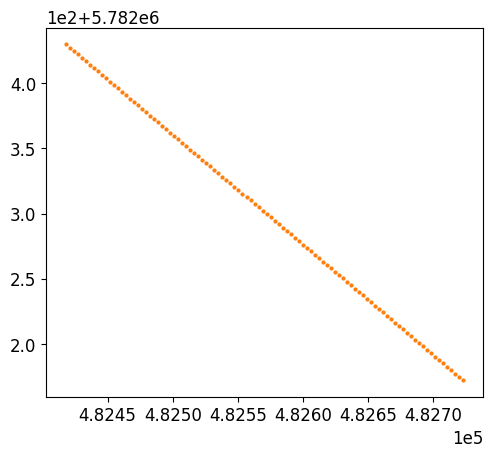

In [29]:
#side 4 solution 
side_four_points = np.vstack((x4,y4)).T

#plot transect over mesh grid
fig, axes = icepack.plot.subplots()
#colors = icepack.plot.tripcolor(u_shear, vmin=0, vmax=20,axes=axes)
axes.scatter(side_four_points[:,0], side_four_points[:,1], 4.0, "tab:orange");

#print(side_four_points)
#create a vertex only mesh from repeating list of gridded coordinates,p
#'warn' missing points is supposed to remove those coordinates not within mesh domain
vom = firedrake.VertexOnlyMesh(mesh2d, side_four_points, missing_points_behaviour="warn")
#P0DG = FunctionSpace(vom, "DG", 0)

#Get coordinates of mesh that should still be regularly spaced, but with points outside mesh removed
side_four_points = vom.coordinates.dat.data

#now that you've gotten coordinates from inside vom, append 1 back to z-coordinate for sampling stress solutions
side_four_points = np.append(side_four_points, np.ones([len(side_four_points),1]), 1)

#print(side_four_points)

#sample along side 2 (lateral R_xy)
R_xx_points = np.array(R_xx.at(side_four_points, tolerance=1e-10))
R_xy_points = np.array(R_xy.at(side_four_points, tolerance=1e-10))
R_yx_points = np.array(R_yx.at(side_four_points, tolerance=1e-10))
R_yy_points = np.array(R_yy.at(side_four_points, tolerance=1e-10))

#sample ice thickness at same points
h_points = np.array(h0.at(side_four_points, tolerance=1e-10))



#print(R_xy_points)
#print(R_yx_points)
#print(len(R_yx_points))

#rotation matrix; can't get variable names to give 2by2 matrix; gives 2by2by1 which doesn't work
rot1 = np.array([[0.70710678, -0.70710678], [0.70710678, 0.70710678]])
#rot1 = np.array([[theta1, theta2], [theta3, theta4]]) 
print(rot1)
print(rot1.shape)

#rot2 = np.array([[theta1, theta3], [theta2, theta4]]) 
rot2 = np.array([[0.70710678, 0.70710678], [-0.70710678, 0.70710678]])
print(rot2)
print(rot2.shape)

#put the first four components into a 2 by 2 matrix for rotattion calculation
#stress_tensor_test = np.array([[R_xx_points[2430], R_xy_points[2430]], [R_yx_points[2430], R_yy_points[2430]]])
#print(stress_tensor.shape)

#initialize a n by 4 array for rotated points
rot_R = np.zeros((len(R_xy_points),4))
print(rot_R.shape)

#create loop to pull 4 components and rotate them for each point
for i in range(len(R_xx_points)):
    
    #put the first four components into a 2 by 2 matrix for rotattion calculation
    #stress_tensor = np.array([[R_xx_points[0], R_xy_points[0]], [R_yx_points[0], R_yy_points[0]]])
    stress_tensor = np.array([[R_xx_points[i], R_xy_points[i]], [R_yx_points[i], R_yy_points[i]]])
    #print(stress_tensor.shape)
    #print(i)
    
    #apply rotation matrices
    rot_stress = np.dot(rot1, stress_tensor) 
    rot_stress2 = np.dot(rot_stress, rot2)  
    
    rot_R[i,0] = rot_stress2[0,0]
    rot_R[i,1] = rot_stress2[0,1]
    rot_R[i,2] = rot_stress2[1,0]
    rot_R[i,3] = rot_stress2[1,1]
    

#print(stress_tensor.shape)  
#print(i)
#print part of the rotated solution
print(rot_R[0:10,:])

#example for 45 degree rotation; answer should 'swap' values with non-zero stress on diagonal (xx,yy)
stress_tensor_test = np.array([[0, 10,], [10, 0]])
print(stress_tensor_test)
print(stress_tensor_test.shape)

#apply rotation matrices
rot_stress = np.dot(rot1, stress_tensor_test) 
rot_stress2 = np.dot(rot_stress, rot2)  

#print(rot_stress)
print(rot_stress2)

#find the average H*R_xy value for side 1
side4_sol = (h_points*rot_R[:,0])
print(side4_sol)
#print(rot_R[:,1])
#print(rot_R[:,2])
#print(h_points)

#find average value
side4_sol_mean = np.mean(side4_sol)
print(side4_sol_mean)

In [30]:
f_lon = (side2_sol_mean-side4_sol_mean)/400
print(f_lon)

f_lat = (side3_sol_mean-side1_sol_mean)/400
print(f_lat)

print(mean_τ_d)

t_base = mean_τ_d + f_lon + f_lat

print(t_base)


0.0027925691714071276
-0.041519211880380345
0.1198161460980014
0.08108950338902818


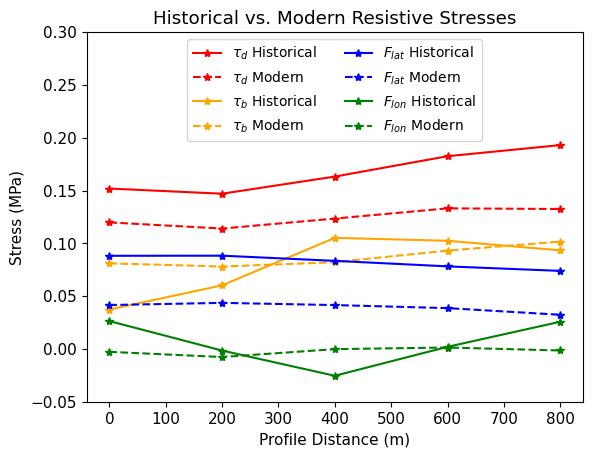

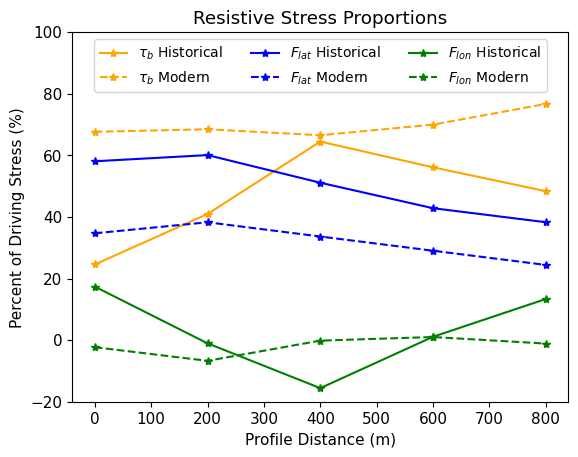

In [31]:
#plot the 'moving box' stress results
plt.rcParams.update({'font.size': 11})
x_box = [0,200,400,600,800]

f_lon_hist = np.array([-0.02638,0.00154,0.02544,-0.001980,-0.02574])

f_lon_mod = np.array([0.00276,0.00766,0.0002037,-0.001338,0.00148])

f_lat_hist = np.array([-0.08819,-0.0883,-0.0834,-0.07817,-0.07389])

f_lat_mod = np.array([-0.04155,-0.04362,-0.04152,-0.03864,-0.03235])

t_d_hist = np.array([0.15187,0.14699,0.1632,0.1825,0.19299])

t_d_mod = np.array([0.1198,0.1140,0.12343,0.13312,0.1325])

t_b_hist = np.array([0.0373,0.0602,0.1052,0.1024,0.09335])

t_b_mod = np.array([0.08103,0.07804,0.08211,0.09314,0.10163])

hist_long_percent = (f_lon_hist)/t_d_hist*-100
hist_lat_percent = f_lat_hist/t_d_hist*-100
hist_t_b_percent = t_b_hist/t_d_hist*100

mod_long_percent = f_lon_mod/t_d_mod*-100
mod_lat_percent = f_lat_mod/t_d_mod*-100
mod_t_b_percent = t_b_mod/t_d_mod*100

fig, axes = plt.subplots()
axes.plot(x_box, t_d_hist, '-*', color="red")
axes.plot(x_box, t_d_mod, '--*', color="red")
axes.plot(x_box, t_b_hist, '-*', color="orange")
axes.plot(x_box, t_b_mod, '--*', color="orange")
axes.plot(x_box, -1*f_lat_hist, '-*', color="blue")
axes.plot(x_box, -1*f_lat_mod, '--*', color="blue")
axes.plot(x_box, -1*f_lon_hist, '-*', color="green")
axes.plot(x_box, -1*f_lon_mod, '--*', color="green")


#plt.legend(loc='upper center',ncol=3,prop={'size":8}),

plt.legend(['$τ_{d}$ Historical', '$τ_{d}$ Modern', '$τ_{b}$ Historical', '$τ_{b}$ Modern','$F_{lat}$ Historical', '$F_{lat}$ Modern','$F_{lon}$ Historical', '$F_{lon}$ Modern'],loc='upper center',ncol=2,prop={'size':10})
axes.set_xlabel('Profile Distance (m)')
axes.set_ylabel('Stress (MPa)');
axes.set_title('Historical vs. Modern Resistive Stresses');
ax = plt.gca()
#ax.set_xlim([-100, 1000])
ax.set_ylim([-0.05, 0.30])
plt.savefig('/Users/davidpolashenski/Desktop/Figure18.png',dpi=1600, facecolor='w', edgecolor='w',)


fig, axes = plt.subplots()
axes.plot(x_box, hist_t_b_percent, '-*', color="orange")
axes.plot(x_box, mod_t_b_percent, '--*', color="orange")
axes.plot(x_box, hist_lat_percent, '-*', color="blue")
axes.plot(x_box, mod_lat_percent, '--*', color="blue")
axes.plot(x_box, hist_long_percent, '-*', color="green")
axes.plot(x_box, mod_long_percent, '--*', color="green")


plt.legend(['$τ_{b}$ Historical', '$τ_{b}$ Modern','$F_{lat}$ Historical', '$F_{lat}$ Modern','$F_{lon}$ Historical', '$F_{lon}$ Modern'],loc='upper center',ncol=3,prop={'size':10})
axes.set_xlabel('Profile Distance (m)')
axes.set_ylabel('Percent of Driving Stress (%)');
axes.set_title('Resistive Stress Proportions');
ax = plt.gca()
#ax.set_xlim([-50, 900])
ax.set_ylim([-20, 100])
plt.savefig('/Users/davidpolashenski/Desktop/Figure20.png',dpi=1600, facecolor='w', edgecolor='w',)


In [32]:
#Raymond cross section
x2 = np.linspace(4.8217e5,4.8271e5,100)
y2 = np.linspace(5.7824e6,5.78193e6,100)

#create regularly sampled grid of UTM coordinates over model domain: SET HERE DJP
E_min = 4.817e5
E_max = 4.842e5
N_min = 5.7815e6
N_max = 5.7847e6
xi = np.linspace(E_min,E_max,25)
yi = np.linspace(N_min,N_max,25)
X,Y = np.meshgrid(xi,yi)

p_2d = np.array([(x,y) for x in xi for y in yi])
p_3d = np.array([(x,y,1) for x in xi for y in yi])

#print(p_3d)
print(len(p_3d))

#create a vertex only mesh from repeating list of gridded coordinates,p
#'warn' missing points is supposed to remove those coordinates not within mesh domain
vom = firedrake.VertexOnlyMesh(mesh2d, p_2d, missing_points_behaviour="warn")
#P0DG = FunctionSpace(vom, "DG", 0)

#Get coordinates of mesh that should still be regularly spaced, but with points outside mesh removed
sample_points = vom.coordinates.dat.data

#now that you've gotten coordinates from inside vom, append 1 back to z-coordinate for sampling stress solutions
sample_points = np.append(sample_points, np.ones([len(sample_points),1]), 1)
#print(sample_points)
print(len(sample_points))


#membrane_inv is four-component tensor so need to interpolate each component individually
#R_xy and R_yx are symmetric/equal
R_xx = firedrake.interpolate(membrane_inv[0,0],Q)
R_xy = firedrake.interpolate(membrane_inv[1,0],Q)
R_yx = firedrake.interpolate(membrane_inv[0,1],Q)
R_yy = firedrake.interpolate(membrane_inv[1,1],Q)

#sample at discrete points in the mesh
R_xx_points = np.array(R_xx.at(sample_points, tolerance=1e-10))
R_xy_points = np.array(R_xy.at(sample_points, tolerance=1e-10))
R_yx_points = np.array(R_yx.at(sample_points, tolerance=1e-10))
R_yy_points = np.array(R_yy.at(sample_points, tolerance=1e-10))

#sample ice thickness at same points
h_points = np.array(h0.at(sample_points, tolerance=1e-10))

#sample driving stress at same points
τ_d_points = np.array(driving_plot.at(sample_points, tolerance=1e-10))

625
129


/Users/davidpolashenski/firedrake/src/firedrake/firedrake/mesh.py:2415: UserWarning: 496 vertices are outside the mesh and have been removed from the VertexOnlyMesh
  warn(msg)


In [33]:
#theta = np.sin(45.*np.pi/180)

theta = [45.*np.pi/180]

theta1 = np.cos(theta)
theta2 = np.sin(theta)*-1
theta3 = np.sin(theta)
theta4 = np.cos(theta)

#print(theta3)

#rotation matrix; can't get variable names to give 2by2 matrix; gives 2by2by1 which doesn't work
rot1 = np.array([[0.70710678, -0.70710678], [0.70710678, 0.70710678]])
#rot1 = np.array([[theta1, theta2], [theta3, theta4]]) 
print(rot1)
print(rot1.shape)

#rot2 = np.array([[theta1, theta3], [theta2, theta4]]) 
rot2 = np.array([[0.70710678, 0.70710678], [-0.70710678, 0.70710678]])
print(rot2)
print(rot2.shape)

#put the first four components into a 2 by 2 matrix for rotattion calculation
#stress_tensor_test = np.array([[R_xx_points[2430], R_xy_points[2430]], [R_yx_points[2430], R_yy_points[2430]]])
#print(stress_tensor.shape)

#initialize a n by 4 array for rotated points
rot_R = np.zeros((len(R_xx_points),4))
print(rot_R.shape)

#create loop to pull 4 components and rotate them for each point
for i in range(len(R_xx_points)):
    
    #put the first four components into a 2 by 2 matrix for rotattion calculation
    #stress_tensor = np.array([[R_xx_points[0], R_xy_points[0]], [R_yx_points[0], R_yy_points[0]]])
    stress_tensor = np.array([[R_xx_points[i], R_xy_points[i]], [R_yx_points[i], R_yy_points[i]]])
    #print(stress_tensor.shape)
    #print(i)
    
    #apply rotation matrices
    rot_stress = np.dot(rot1, stress_tensor) 
    rot_stress2 = np.dot(rot_stress, rot2)  
    
    rot_R[i,0] = rot_stress2[0,0]
    rot_R[i,1] = rot_stress2[0,1]
    rot_R[i,2] = rot_stress2[1,0]
    rot_R[i,3] = rot_stress2[1,1]
    

#print(stress_tensor.shape)  
#print(i)
#print part of the rotated solution
print(rot_R[0:10,:])

#example for 45 degree rotation; answer should 'swap' values with non-zero stress on diagonal (xx,yy)
stress_tensor_test = np.array([[0, 10,], [10, 0]])
print(stress_tensor_test)
print(stress_tensor_test.shape)

#apply rotation matrices
rot_stress = np.dot(rot1, stress_tensor_test) 
rot_stress2 = np.dot(rot_stress, rot2)  

#print(rot_stress)
print(rot_stress2)

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
(2, 2)
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
(2, 2)
(129, 4)
[[ 0.10224848  0.0426255   0.0426255  -0.03193056]
 [ 0.07026823  0.00335372  0.00335372  0.12141492]
 [ 0.00484344  0.01898201  0.01898201 -0.00702072]
 [-0.04287626  0.03088521  0.03088521 -0.09168042]
 [-0.04703589  0.12107842  0.12107842  0.02307559]
 [ 0.01846823  0.00910791  0.00910791  0.05980663]
 [ 0.00850365  0.01307792  0.01307792  0.00825535]
 [ 0.0122404   0.02225521  0.02225521 -0.04027508]
 [-0.01170912  0.06446414  0.06446414 -0.02911351]
 [-0.00847476  0.08727605  0.08727605  0.02910248]]
[[ 0 10]
 [10  0]]
(2, 2)
[[-9.99999997e+00 -2.79374445e-16]
 [ 2.79374445e-16  9.99999997e+00]]


In [34]:
#determine the indices of in p_3d where sample points (R_xx, etc inside model domain) are pulled from
ind=[]
for elements in list(map(tuple,sample_points)):
    ind.append(list(map(tuple,p_3d)).index(elements))

#print(ind)
print(len(ind))

#print(p_3d[ind,:])

129


In [35]:
print(R_xx_points[0:9])
print(rot_R[0:9,:])

#make a placeholder matrix that is the size you want it to be for later calculations
#holder = np.zeros(len(p_3d))
R_xx_rot = np.zeros(len(p_3d))
R_xy_rot = np.zeros(len(p_3d))
R_yx_rot = np.zeros(len(p_3d))
R_yy_rot = np.zeros(len(p_3d))
H_samples = np.zeros(len(p_3d))
τ_d_samples = np.zeros(len(p_3d))

#print(holder)
#print(len(holder))

#use np.put to place the R_xx_points at specific indices determined from above; DON'T SET EQUAL TO NEW VARIABLE
#RETURNS NONE INSTEAD OF VALUES PLACED CORRECTLY
#np.put(holder, ind, R_xx_points)
np.put(R_xx_rot, ind, rot_R[:,0])
np.put(R_xy_rot, ind, rot_R[:,1])
np.put(R_yx_rot, ind, rot_R[:,2])
np.put(R_yy_rot, ind, rot_R[:,3])
np.put(H_samples, ind, h_points)
np.put(τ_d_samples, ind, τ_d_points)

#print(holder)
#print(len(holder))

#reshape the stress values to correct places on sample coordinates from above to allow for differentiation
R_xx_grid = R_xx_rot.reshape(25,25)
R_xy_grid = R_xy_rot.reshape(25,25)
R_yx_grid = R_yx_rot.reshape(25,25)
R_yy_grid = R_yy_rot.reshape(25,25)
H_grid = H_samples.reshape(25,25)
τ_d_grid = τ_d_samples.reshape(25,25)

#can look at a single row/column to make sure makes sense with indices above (appears to)
print(H_grid[8,:])
print(τ_d_grid[8,:])

[ 0.07778446  0.0991953   0.01789336 -0.03639313  0.10909827  0.04824534
  0.02145742  0.00823787  0.04405283]
[[ 0.10224848  0.0426255   0.0426255  -0.03193056]
 [ 0.07026823  0.00335372  0.00335372  0.12141492]
 [ 0.00484344  0.01898201  0.01898201 -0.00702072]
 [-0.04287626  0.03088521  0.03088521 -0.09168042]
 [-0.04703589  0.12107842  0.12107842  0.02307559]
 [ 0.01846823  0.00910791  0.00910791  0.05980663]
 [ 0.00850365  0.01307792  0.01307792  0.00825535]
 [ 0.0122404   0.02225521  0.02225521 -0.04027508]
 [-0.01170912  0.06446414  0.06446414 -0.02911351]]
[  0.           0.         128.46009305 161.58521256 231.8555997
 250.60443381 262.30840214 258.12558104 244.9248706  202.8525551
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.        ]
[0.         0.         0.0828347  0.10303138 0.12655592 0.14403003
 0.15458566 0.1456097  0.12483603 0.12247739 0.  

In [36]:
xi = np.linspace(E_min,E_max,25)
yi = np.linspace(N_min,N_max,25)

#determine the grid cell sizes
del_x = (E_max-E_min)/25
del_y = (N_max-N_min)/25

print(del_x)
print(del_y)

#initalize array to hold longitudinal and lateral forces calculated in for loop 
s=(25,25)
F_lon = np.zeros(s)
F_lat = np.zeros(s)
τ_base = np.zeros(s)

#print(τ_d_grid[10,:])

#create loop to calculate the longitudinal force
for i in range(1,24):
    for j in range(0,25):
        F_lon[i,j] = ((H_grid[i+1,j]*R_xx_grid[i+1,j])-(H_grid[i-1,j]*R_xx_grid[i-1,j]))/(2*del_x)
        
#print(F_lon[10,:])


#create loop to calculate the lateral force
for i in range(0,25):
    for j in range(1,24):
        F_lat[i,j] = ((H_grid[i,j+1]*R_xy_grid[i,j+1])-(H_grid[i,j-1]*R_xy_grid[i,j-1]))/(2*del_y)
        
#print(F_lat[10,:])

#loop to calculate basal shear stress
for i in range(0,25):
    for j in range(0,25):
        τ_base[i,j] = ((τ_d_grid[i,j])+(F_lon[i,j])+(F_lat[i,j]))

print(τ_base[8,:])

100.0
128.0
[ 0.         -0.03381584  0.07153696  0.07478221  0.1306508   0.17014734
  0.18923143  0.17308028  0.16495229  0.01147144 -0.141474    0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]


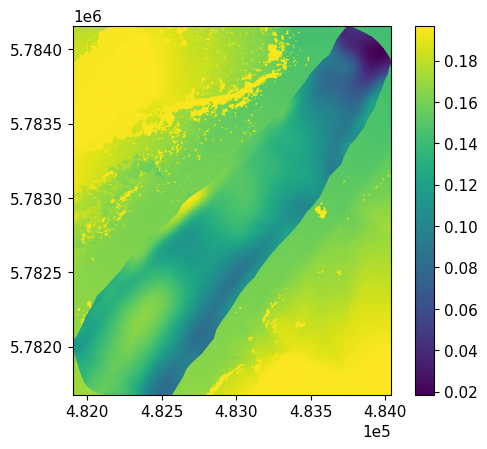

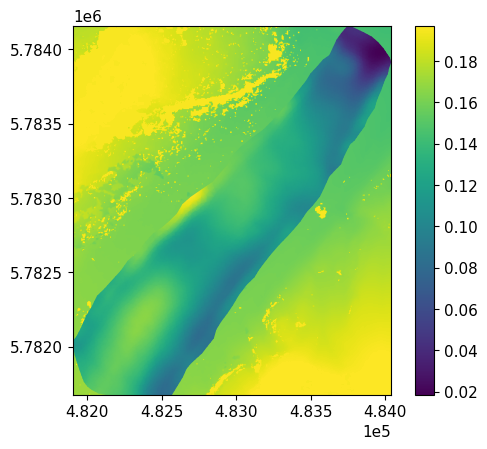

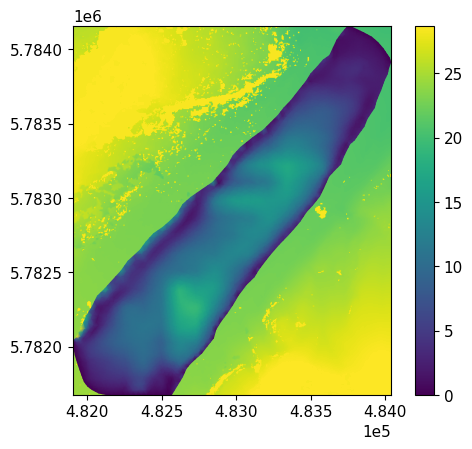

In [37]:
#driving stress sanity checks

fig, axes = subplots()
colors = icepack.plot.tripcolor(τ, axes=axes)
fig.colorbar(colors);

fig, axes = subplots()
colors = icepack.plot.tripcolor(driving_plot, axes=axes)
fig.colorbar(colors);

δu = firedrake.interpolate(sqrt(inner(u_inverse - u_obs, u_inverse - u_obs)), Q)

fig, axes = subplots()
colors = icepack.plot.tripcolor(δu, axes=axes)
fig.colorbar(colors);

w⃗₅₅₀₇
w⃗₅₇₉₂
[[4.82077177e+05 5.78168906e+06 0.00000000e+00]
 [4.82077177e+05 5.78168906e+06 1.00000000e+00]
 [4.82032261e+05 5.78171233e+06 0.00000000e+00]
 ...
 [4.84037981e+05 5.78391150e+06 1.00000000e+00]
 [4.84023568e+05 5.78387047e+06 0.00000000e+00]
 [4.84023568e+05 5.78387047e+06 1.00000000e+00]]
[[4.82077177e+05 5.78168906e+06 1.00000000e+00]
 [4.82032261e+05 5.78171233e+06 1.00000000e+00]
 [4.82069314e+05 5.78173496e+06 1.00000000e+00]
 ...
 [4.83998067e+05 5.78389175e+06 1.00000000e+00]
 [4.84037981e+05 5.78391150e+06 1.00000000e+00]
 [4.84023568e+05 5.78387047e+06 1.00000000e+00]]
[[ 482077.177062   5781689.060271  ]
 [ 482032.261193   5781712.329161  ]
 [ 482069.31408281 5781734.96198375]
 ...
 [ 483998.06698943 5783891.75471634]
 [ 484037.980873   5783911.495733  ]
 [ 484023.567974   5783870.474407  ]]


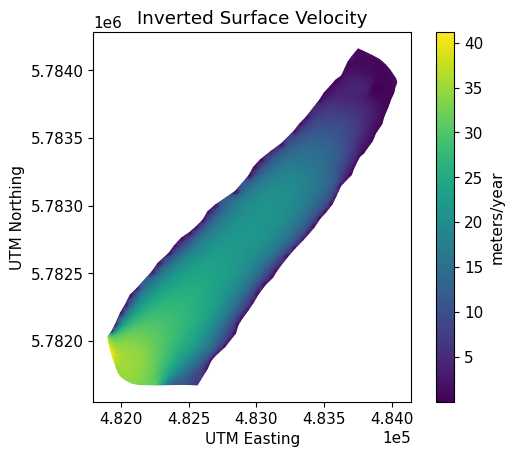

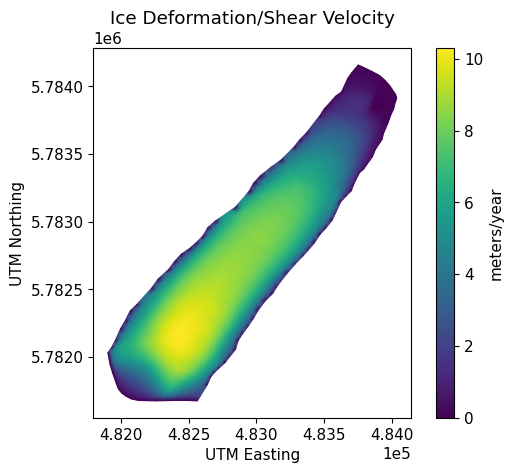

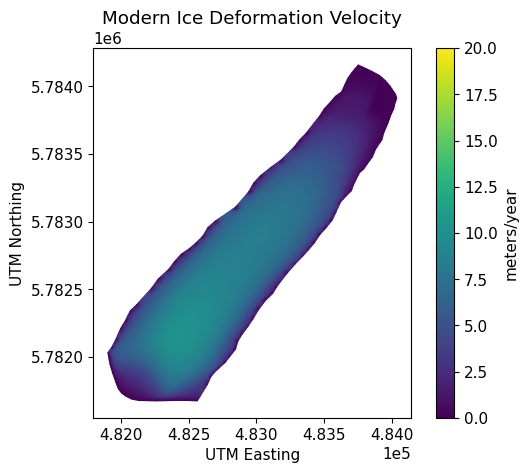

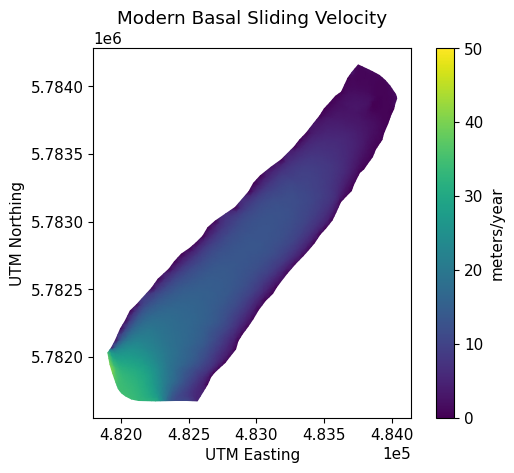

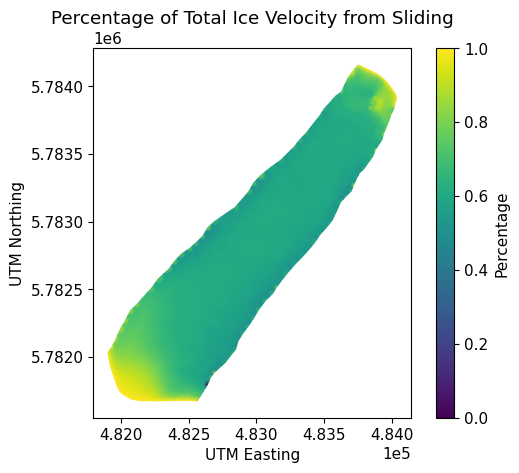

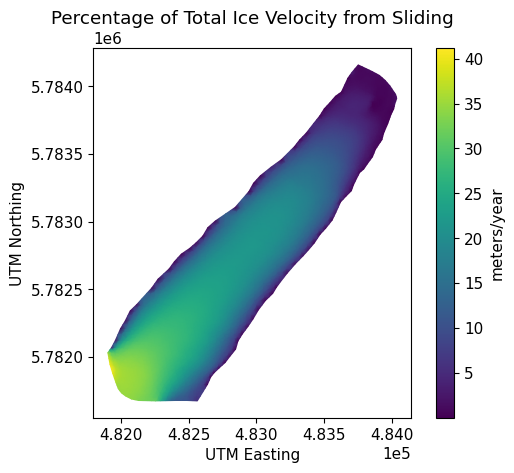

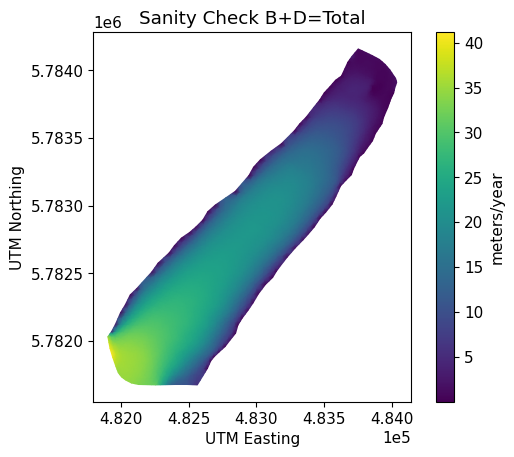

In [38]:
u_shear = icepack.depth_average(u_inverse, weight=np.sqrt(3) * (2 * ζ - 1))

#u_shear.ufl_domain() is mesh2d
u_shear.ufl_domain() is mesh

fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(u_inverse, axes=axes)
fig.colorbar(colors, orientation="vertical", label="meters/year");
axes.set_title('Inverted Surface Velocity');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure20.png',dpi=1500, facecolor='w', edgecolor='w',)


print(u_inverse)
print(u_shear)

fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(u_shear, axes=axes)
fig.colorbar(colors, orientation="vertical", label="meters/year");
axes.set_title('Ice Deformation/Shear Velocity');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure21.png',dpi=1500, facecolor='w', edgecolor='w',)

#u_inverse_mag = (((u_inverse[:,0])**2) + ((u_inverse[:,1])**2))**0.5

from firedrake import inner, sqrt


#calculate shear and plug flow velocity components and ratio
u_avg = icepack.depth_average(u_inverse)

Q2D = firedrake.FunctionSpace(mesh2d, "CG", 2)
U_shear = sqrt(inner(u_shear, u_shear))
U_avg = sqrt(inner(u_avg, u_avg))
U_base = U_avg-U_shear
ratio = U_base/U_avg


#on function space Q or Q2D
U_shear_file = firedrake.interpolate(U_shear, Q2D)
U_shear_plot = firedrake.interpolate(U_shear, Q2D)
U_avg_plot = firedrake.interpolate(U_avg, Q2D)
U_base_plot = firedrake.interpolate(U_base,Q2D)
#Ratio of total velocity that is basal sliding
ratio_plot = firedrake.interpolate(U_base/U_avg, Q2D)


#ratio = firedrake.interpolate(U_shear / U_avg, u_avg.function_space())

# #u_base.ufl_domain() is mesh2d

fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(U_shear_plot, axes=axes, vmin=0, vmax=20)
fig.colorbar(colors, orientation="vertical", label="meters/year");
axes.set_title('Modern Ice Deformation Velocity');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure22.png',dpi=1500, facecolor='w', edgecolor='w',)

#Get coordinates of mesh
points = mesh.coordinates.dat.data
print(points)

#slice the list to get only z-values equal to 1
points = points[1::2]


print(points)
#here the mesh is only 2D so give it points list that has only x/y UTM coordinates, not z as above
points = points[:,:2]

#extract data values as numpy array at those coordinates
#ModShearVel = np.array(U_shear_file.at(points, tolerance=1e-10))
#ModShearVel_Mag = (((ModShearVel[:,0])**2) + ((ModShearVel[:,1])**2))**0.5

#save velocity solution at those points to csv file
#np.savetxt("ModernDeformationVelocity.csv",ModDefVel_Mag,
#              delimiter = ",")

#here the mesh is only 2D so give it points list that has only x/y UTM coordinates, not z as above
#points = points[:,:2]
print(points)

#extract data values as numpy array at those coordinates
ModDefVel = np.array(U_shear_plot.at(points, tolerance=1e-6))
ModBaseVel = np.array(U_base_plot.at(points, tolerance=1e-6))
Modratio = np.array(ratio_plot.at(points, tolerance=1e-6))
#ModDefVel_Mag = (((ModDefVel[:,0])**2) + ((ModDefVel[:,1])**2))**0.5

#print(ModDefVel)

#save velocity solution at those points to csv file
np.savetxt("ModernDeformationVelocity.csv",ModDefVel,
             delimiter = ",")

np.savetxt("ModernBasalVelocity.csv",ModBaseVel,
             delimiter = ",")

np.savetxt("ModernRatioVelocity.csv",Modratio,
             delimiter = ",")


fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(U_base_plot, axes=axes, vmin=0, vmax=50)
fig.colorbar(colors, orientation="vertical", label="meters/year");
axes.set_title('Modern Basal Sliding Velocity');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure23.png',dpi=1500, facecolor='w', edgecolor='w',)

fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(ratio_plot, vmin = 0, vmax =1,axes=axes)
fig.colorbar(colors, orientation="vertical", label="Percentage");
axes.set_title('Percentage of Total Ice Velocity from Sliding');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure24.png',dpi=1500, facecolor='w', edgecolor='w',)

basal= u_inverse*ratio

#basal_plot= firedrake.interpolate(basal, Q2D)

fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(U_avg_plot, axes=axes)
fig.colorbar(colors, orientation="vertical", label="meters/year");
axes.set_title('Percentage of Total Ice Velocity from Sliding');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure25.png',dpi=1500, facecolor='w', edgecolor='w',)



u_check = U_shear+U_base
u_check_plot = firedrake.interpolate(u_check, Q2D)
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(u_check_plot, axes=axes)
fig.colorbar(colors, orientation="vertical", label="meters/year");
axes.set_title('Sanity Check B+D=Total');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure26.png',dpi=1500, facecolor='w', edgecolor='w',)

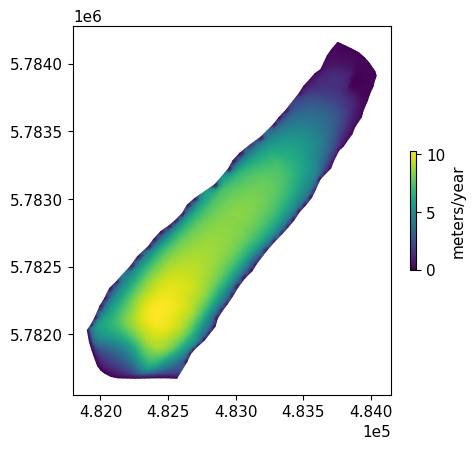

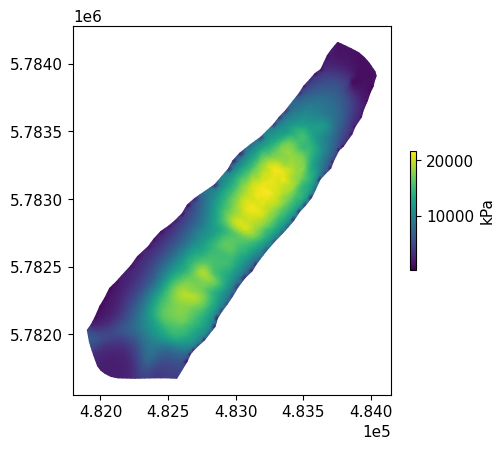

In [39]:
u_shear = icepack.depth_average(u_inverse, weight=np.sqrt(3) * (2 * ζ - 1))

#u_shear.ufl_domain() is mesh2d

fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(u_shear, axes=axes)
fig.colorbar(colors, label="meters/year", fraction=0.012, pad=0.04);


#u_base = u_inverse-u_shear

# #u_base.ufl_domain() is mesh2d

#fig, axes = icepack.plot.subplots()
#colors = icepack.plot.tripcolor(u_base, axes=axes)
#fig.colorbar(colors, label="meters/year", fraction=0.012, pad=0.04);


expr = -1e3 * C * sqrt(inner(u_inverse, u_inverse)) ** (1 / m - 1) * u_inverse
τ_b = firedrake.interpolate(expr, V)
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(τ_b, axes=axes)
fig.colorbar(colors, label="kPa", fraction=0.012, pad=0.04);

##WORKS TO HERE, VARIABLE NAMES AND CODE NOT UPDATED PAST THIS!!!! 2-10-23


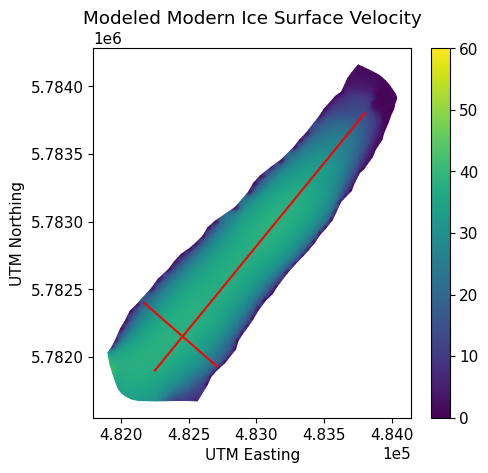

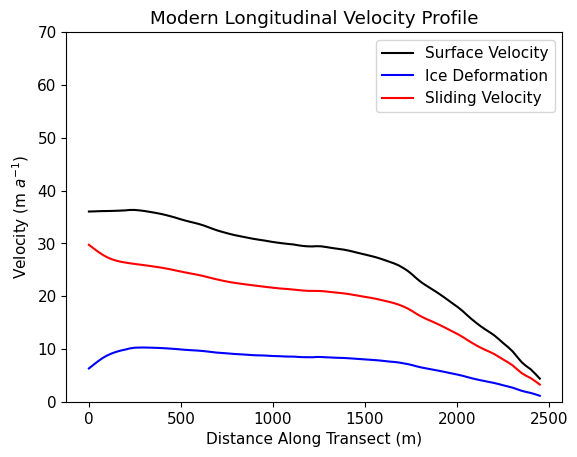

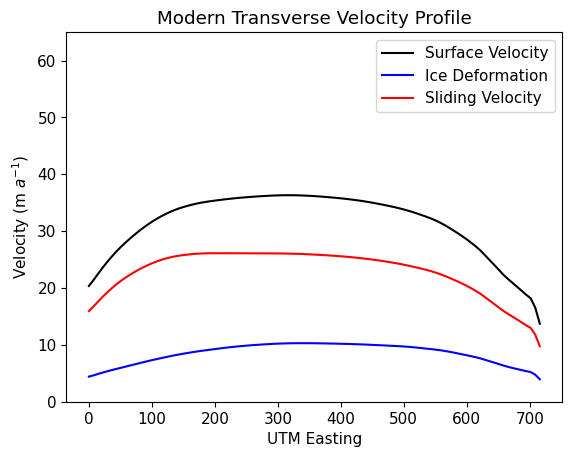

In [40]:
#be careful with double variable use!, x, y, z defined above in mesh coordinates
#set up centerline transect
x = np.linspace(4.8225e5,4.838e5,100)
y = np.linspace(5.7819e6,5.7838e6,100)
#z = np.linspace(0,1,100)

#pair the x, y corrdinates into single array
xs = np.zeros((len(x), 2))
xs[:,0] = x
xs[:,1] = y
#xs[:,2] = z




#Raymond cross section
x2 = np.linspace(4.8217e5,4.8271e5,100)
y2 = np.linspace(5.7824e6,5.78193e6,100)
z2 = np.linspace(1,1,100)

#with z from 3D mesh 
xs2 = np.zeros((len(x2), 3))
xs2[:,0] = x2
xs2[:,1] = y2
xs2[:,2] = z2

#without z, for solutions only on 2D/VOM
xs3 = np.zeros((len(x2), 2))
xs3[:,0] = x2
xs3[:,1] = y2

#plot transect over mesh grid
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(u, vmin=0, vmax=60,axes=axes)
axes.plot(x,y, color='red')
axes.plot(x2,y2, color='red')
fig.colorbar(colors, ax=axes, fraction=.1, pad=0.04);
axes.set_title('Modeled Modern Ice Surface Velocity');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('UTM Northing');
plt.savefig('/Users/davidpolashenski/Desktop/Figure13.png',dpi=1500, facecolor='w', edgecolor='w',)
    
#This is syntax to access modeled value for any grid point within the mesh domain
#check = s([4.8255e5,5.7825e6])
#print(check)

#stored as vx, vy in two columns
plot_shear = np.array(u_shear.at(xs, tolerance=1e-10))
#convert to velocity magnitude
test = ((plot_shear[:,0])**2)
shear_mag = (((plot_shear[:,0])**2) + ((plot_shear[:,1])**2))**0.5
#hs = np.array(h.at(xs, tolerance=1e-10))
#bs = np.array(b.at(xs, tolerance=1e-10))
#us = np.array(u.at(xs, tolerance=1e-10))

#extract surface velocity and shear velocity for transverse/Raymond Profile
u_inv2 = np.array(u_inverse.at(xs2, tolerance=1e-10))
u_inv_mag2 = (((u_inv2[:,0])**2) + ((u_inv2[:,1])**2))**0.5
plot_shear2 = np.array(u_shear.at(xs3, tolerance=1e-10))
shear_mag2 = (((plot_shear2[:,0])**2) + ((plot_shear2[:,1])**2))**0.5

#plot along profiles in meters
x_long = np.linspace(0,2452,100);
x_lat = np.linspace(0,716,100);

fig, axes = plt.subplots()
#axes.plot(xs[:, 0] / 1e3, plot_shear, color='black')
axes.plot(x_long, u_inv_mag, label= 'Surface Velocity', color='black')
axes.plot(x_long, shear_mag, label= 'Ice Deformation', color='blue')
axes.plot(x_long, u_inv_mag-shear_mag, label= 'Sliding Velocity', color='red')
axes.legend()
axes.set_title('Modern Longitudinal Velocity Profile');
axes.set_xlabel('Distance Along Transect (m)')
axes.set_ylabel('Velocity (m $a^{-1}$)');
plt.ylim([0, 70])
plt.savefig('/Users/davidpolashenski/Desktop/Figure14.png',dpi=1500, facecolor='w', edgecolor='w',)

#save velocity solution at those points to csv file
np.savetxt("ModernLongTotal.csv",u_inv_mag,
              delimiter = ",")

#save velocity solution at those points to csv file
np.savetxt("ModernLongDef.csv",shear_mag,
              delimiter = ",")

#save velocity solution at those points to csv file
np.savetxt("ModernLongBase.csv",u_inv_mag-shear_mag,
              delimiter = ",")

fig, axes = plt.subplots()
#axes.plot(xs[:, 0] / 1e3, plot_shear, color='black')
axes.plot(x_lat, u_inv_mag2, label= 'Surface Velocity', color='black')
axes.plot(x_lat, shear_mag2, label= 'Ice Deformation', color='blue')
axes.plot(x_lat, u_inv_mag2-shear_mag2, label= 'Sliding Velocity', color='red')
axes.legend()
axes.set_title('Modern Transverse Velocity Profile');
axes.set_xlabel('UTM Easting')
axes.set_ylabel('Velocity (m $a^{-1}$)');
plt.ylim([0, 65])
plt.savefig('/Users/davidpolashenski/Desktop/Figure15.png',dpi=1500, facecolor='w', edgecolor='w',)

#save velocity solution at those points to csv file
np.savetxt("ModernLatTotal.csv",u_inv_mag2,
              delimiter = ",")

#save velocity solution at those points to csv file
np.savetxt("ModernLatDef.csv",shear_mag2,
              delimiter = ",")

#save velocity solution at those points to csv file
np.savetxt("ModernLatBase.csv",u_inv_mag2-shear_mag2,
              delimiter = ",")



#print(plot_shear)